In [63]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


In [64]:
df_ETTh1 = pd.read_csv("ETDataset/ETT-small/final_surgeries.csv")

In [65]:
df_ETTh1.head()
x_y = df_ETTh1.iloc[:,:]
a=x_y.shape[0]
print(a*0.8,a*0.9,a)

529274.4 595433.7000000001 661593


In [66]:
# df_ETTh1.info()
# df_ETTh1 = df_ETTh1.dropna(subset=['bis'])
# df_ETTh1.fillna(method='ffill', inplace=True)



nan_count = df_ETTh1.isna().sum().sum()
print("Number of NaN values:", nan_count)



Number of NaN values: 0


In [67]:
class ETTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset="final_surgeries", mode="train", scale=False, seq_len=1, pred_len=1):       #336,96
        super().__init__()
        df = pd.read_csv("ETDataset/ETT-small/{}.csv".format(dataset))
        x_y = df.iloc[:,:]  ###################################

        self.len = x_y.shape[0]

        time_stamp = df.iloc[:,0]

        assert mode in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[mode]
        
        self.seq_len = seq_len
        self.pred_len = pred_len

        # border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        # border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

        border1s = [0, (529274) - self.seq_len,  595433 - self.seq_len]
        border2s = [529274, 595433, 661593-1]


        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if scale:
            train_x_y = x_y.iloc[border1s[0]: border2s[0]]
            self.ss = StandardScaler()
            self.ss.fit(train_x_y.to_numpy(dtype=np.float32))
            x_y = self.ss.transform(x_y.to_numpy(dtype=np.float32))
        else:
            x_y = x_y.to_numpy(dtype=np.float32)
        
        time_stamp = time_stamp.to_numpy()     
        
        self.data_x = x_y[border1: border2, :4]      ###################################################################################
        print(self.data_x.shape, "x")
        self.data_y = x_y[border1: border2, -1]     ###################################################################################
        print(self.data_y.shape, "y")

        self.data_stamp = time_stamp[border1: border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        return seq_x, seq_y

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.ss.inverse_transform(data)

In [68]:
#implementation of utils
class RevIN(torch.nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False, target_idx=-1):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.target_idx = target_idx
        if self.affine:
            self._init_params()

    def forward(self, x, mode):
        if mode == "norm":
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == "denorm":
            x = self._denormalize(x)
        else: raise AssertionError
        return x

    def _init_params(self):
        self.affine_weight = torch.nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = torch.nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev[:, :, self.target_idx]
        if self.subtract_last:
            x = x + self.last[:, :, self.target_idx]
        else:
            x = x + self.mean[:, :, self.target_idx]
        return x


class Transpose(torch.nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: 
            return x.transpose(*self.dims).contiguous()
        else: 
            return x.transpose(*self.dims)


def positional_encoding(q_len, d_model):
    W_pos = torch.empty((q_len, d_model))
    torch.nn.init.uniform_(W_pos, -0.02, 0.02)
    return torch.nn.Parameter(W_pos, requires_grad=True)

In [69]:
#Implementation of PatchTST Encorder layer
class TSTiEncoder(torch.nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 verbose=False, **kwargs):
        super().__init__()
        self.patch_num = patch_num
        self.patch_len = patch_len
        # Input encoding
        q_len = patch_num
        self.W_P = torch.nn.Linear(patch_len, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len
        # Positional encoding
        self.W_pos = positional_encoding(q_len, d_model)
        # Residual dropout
        self.dropout = torch.nn.Dropout(dropout)
        # Encoder
        self.encoder = TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)

    def forward(self, x):                                              # x: [bs x nvars x patch_len x patch_num]
        
        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x d_model]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x d_model]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x d_model x patch_num]
        
        return z       
            
    
# Cell
class TSTEncoder(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None, 
                        norm='BatchNorm', attn_dropout=0., dropout=0., 
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = torch.nn.ModuleList([TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src, key_padding_mask=None, attn_mask=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: 
                output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: 
                output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output



class TSTEncoderLayer(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = torch.nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = torch.nn.Sequential(Transpose(1,2), torch.nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = torch.nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = torch.nn.Sequential(torch.nn.Linear(d_model, d_ff, bias=bias),
                                torch.nn.GELU(),
                                torch.nn.Dropout(dropout),
                                torch.nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = torch.nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = torch.nn.Sequential(Transpose(1,2), torch.nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = torch.nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn


    def forward(self, src, prev=None, key_padding_mask=None, attn_mask=None):

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src
        

class _MultiheadAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None, res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        super().__init__()
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = torch.nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = torch.nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = torch.nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout, res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = torch.nn.Sequential(torch.nn.Linear(n_heads * d_v, d_model), torch.nn.Dropout(proj_dropout))

    def forward(self, Q, K=None, V=None, prev=None,
                key_padding_mask=None, attn_mask=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s, prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights


class _ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = torch.nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = torch.nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q, k, v, prev=None, key_padding_mask=None, attn_mask=None):
        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

In [70]:
#Implementation of head layer

class Flatten_Head(torch.nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = torch.nn.Flatten(start_dim=-3)
        self.linear = torch.nn.Linear(nf * n_vars, target_window) 
        self.dropout = torch.nn.Dropout(head_dropout)
            
    def forward(self, x):                                 # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)                               # x: [bs x nvars * d_model * patch_num]
        x = self.linear(x)                                # x: [bs x target_window]
        x = self.dropout(x)
        return x
        

In [71]:
#Implementation of PatchTST

class PatchTST(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, max_seq_len=1024, 
                 n_layers=3, d_model=16, n_heads=4, d_k=None, d_v=None,
                 d_ff=128, attn_dropout=0.0, dropout=0.3, key_padding_mask='auto',
                 padding_var=None, attn_mask=None, res_attention=True, pre_norm=False, store_attn=False,
                 head_dropout = 0.0, padding_patch = "end",
                 revin = True, affine = False, subtract_last = False,
                 verbose=False, target_idx=-1, **kwargs):
        super().__init__()

        self.revin = revin
        if revin:
            self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last, target_idx=target_idx)

        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((context_window - patch_len)/stride + 1)

        if padding_patch == "end":
            self.padding_patch_layer = torch.nn.ReplicationPad1d((0, stride))
            patch_num += 1

        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                attn_dropout=attn_dropout, dropout=dropout, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                verbose=verbose, **kwargs)
        
        self.head_nf = d_model * patch_num
        self.n_vars = c_in

        self.head = Flatten_Head(self.n_vars, self.head_nf, target_window, head_dropout=head_dropout)
        
    def forward(self, z):                                                                   # z: [bs x seq_len × nvars]
        # instance norm
        if self.revin:                                                        
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)                                                            # z: [bs x nvars × seq_len]
            
        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]
        
        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x d_model x patch_num]
        z = self.head(z)                                                                    # z: [bs x target_window] 
        
        # denorm
        if self.revin:                                                        
            z = self.revin_layer(z, 'denorm')
        return z


In [72]:
#Linear model
class Linear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        self.c_in = c_in
        self.context_winsoq = context_window
        self.target_window = target_window

        self.flatten = torch.nn.Flatten(start_dim=-2)

        self.linear = torch.nn.Linear(c_in * context_window, target_window)
    
    def forward(self, x):                   # x: [bs x seq_len × nvars]
        x = self.flatten(x)                 # x: [bs x seq_len * nvars]
        x = self.linear(x)                  # x: [bs x target_window]
        return x
    

class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.flatten_Seasonal = torch.nn.Flatten(start_dim=-2)
        self.flatten_Trend = torch.nn.Flatten(start_dim=-2)
        
        self.Linear_Seasonal = torch.nn.Linear(c_in * context_window, target_window)
        self.Linear_Trend = torch.nn.Linear(c_in * context_window, target_window)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init = self.flatten_Seasonal(x)
        trend_init = self.flatten_Trend(x)

        seasonal_output = self.Linear_Seasonal(seasonal_init)
        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x


In [73]:
# class Learner:
#     def __init__(self, model, dataset, batch_size=128, lr=0.0001, epochs=100, d_model=16, adjust_lr=True, adjust_factor=0.001, context_window=336, target_window=96):
#         self.model = model     #.to("cuda")
#         self.batch_size = batch_size
#         train_dataset = dataset(seq_len = context_window, pred_len = target_window, mode="train")
#         valid_dataset = dataset(seq_len = context_window, pred_len = target_window,mode="val")
#         test_dataset = dataset(seq_len = context_window, pred_len = target_window,mode="test")
#         self.train_datalen = len(train_dataset)
#         self.valid_datalen = len(valid_dataset)
#         self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
#         self.test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#         self.lr=lr
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
#         #self.loss = torch.nn.MSELoss()
#         self.loss = torch.nn.L1Loss()
#         self.epochs = epochs
#         self.target_window=target_window
#         self.best_weight = self.model.state_dict()
#         self.d_model=d_model
#         self.adjust_lr = adjust_lr
#         self.adjust_factor = adjust_factor
    
#     def adjust_learning_rate(self, steps, warmup_step=300, printout=True):
#         if steps**(-0.5) < steps * (warmup_step**-1.5):
#             lr_adjust = (16**-0.5) * (steps**-0.5) * self.adjust_factor
#         else:
#             lr_adjust = (16**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

#         for param_group in self.optimizer.param_groups:
#             param_group['lr'] = lr_adjust
#         if printout: 
#             print('Updating learning rate to {}'.format(lr_adjust))
#         return 

#     def train(self):
#         best_valid_loss = np.inf
#         train_history = []
#         valid_history = []
#         train_steps = 1
#         if self.adjust_lr:
#             self.adjust_learning_rate(train_steps)
#         for epoch in range(self.epochs):
#             print("epoch: ", epoch)
#             #train
#             self.model.train()
#             iter_count = 0
#             total_loss = 0

#             for train_x, train_y in self.train_dataloader:
#                 train_x = train_x #.to("cuda")
#                 train_y = train_y #.to("cuda")
                
#                 print(f"Input sequence shape (seq_x): {train_x.shape}")
#                 print(f"Output sequence shape (seq_y): {train_y.shape}")

#                 pred_y = self.model(train_x)
#                 loss = self.loss(pred_y, train_y)
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
#                 total_loss += loss.item()
#                 iter_count += 1
#                 train_steps += 1
#             if self.adjust_lr:
#                 self.adjust_learning_rate(train_steps)

#             #valid
#             self.model.eval()
#             valid_iter_count = 0
#             valid_total_loss = 0
#             with torch.no_grad():
#                 for valid_x, valid_y in self.valid_dataloader:
#                     valid_x = valid_x#.to("cuda")
#                     valid_y = valid_y#.to("cuda")
#                     pred_y = self.model(valid_x)
#                     loss = self.loss(pred_y, valid_y)
#                     valid_total_loss += loss.item()
#                     valid_iter_count += 1
            
#             total_loss /= iter_count
#             valid_total_loss /= valid_iter_count
#             print("epoch: {} MAE loss: {:.4f} MAE valid loss: {:.4f}".format(epoch, total_loss, valid_total_loss))
#             if best_valid_loss >= valid_total_loss:
#                 self.best_weight = self.model.state_dict()
#                 best_valid_loss = valid_total_loss
#                 print("Best score! Weights of the model are updated!")
#             train_history.append(total_loss)
#             valid_history.append(valid_total_loss)
#         return train_history, valid_history

#     def test(self):
#         self.model.load_state_dict(self.best_weight)
#         self.model.eval()
#         iter_count = 0
#         total_loss = 0
#         with torch.no_grad():
#             for test_x, test_y in self.test_dataloader:
#                 test_x = test_x#.to("cuda")
#                 test_y = test_y#.to("cuda")
#                 pred_y = self.model(test_x)
#                 loss = self.loss(pred_y, test_y)
#                 total_loss += loss.item()
#                 iter_count += 1
#         total_loss /= iter_count
#         print("MAE test loss: {:.4f}".format(total_loss))


In [74]:
# from tqdm import tqdm
# import torch
# import numpy as np

# class Learner:
#     def __init__(self, model, dataset, batch_size=128, lr=0.0001, epochs=100, d_model=16, adjust_lr=True, adjust_factor=0.001, context_window=336, target_window=96):
#         self.model = model
#         self.batch_size = batch_size
#         train_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="train")
#         valid_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="val")
#         test_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="test")
#         self.train_datalen = len(train_dataset)
#         self.valid_datalen = len(valid_dataset)
#         self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
#         self.test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#         self.lr = lr
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
#         self.loss = torch.nn.L1Loss()
#         self.epochs = epochs
#         self.target_window = target_window
#         self.best_weight = self.model.state_dict()
#         self.d_model = d_model
#         self.adjust_lr = adjust_lr
#         self.adjust_factor = adjust_factor
    
#     def adjust_learning_rate(self, steps, warmup_step=300, printout=True):
#         if steps**(-0.5) < steps * (warmup_step**-1.5):
#             lr_adjust = (16**-0.5) * (steps**-0.5) * self.adjust_factor
#         else:
#             lr_adjust = (16**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

#         for param_group in self.optimizer.param_groups:
#             param_group['lr'] = lr_adjust
#         if printout: 
#             print('Updating learning rate to {}'.format(lr_adjust))
#         return 

#     def train(self):
#         best_valid_loss = np.inf
#         train_history = []
#         valid_history = []
#         train_steps = 1
#         if self.adjust_lr:
#             self.adjust_learning_rate(train_steps)
#         epoch_bar = tqdm(range(self.epochs), desc="Total Epochs")
#         for epoch in epoch_bar:
#             print(f"epoch: {epoch}")
#             # train
#             self.model.train()
#             iter_count = 0
#             total_loss = 0
#             with tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.epochs}") as train_bar:
#                 for train_x, train_y in train_bar:
#                     train_x = train_x
#                     train_y = train_y
                    
#                     pred_y = self.model(train_x)
#                     loss = self.loss(pred_y, train_y)
#                     self.optimizer.zero_grad()
#                     loss.backward()
#                     self.optimizer.step()
#                     total_loss += loss.item()
#                     iter_count += 1
#                     train_steps += 1

#                     train_bar.set_postfix(loss=loss.item())
                
#             if self.adjust_lr:
#                 self.adjust_learning_rate(train_steps)

#             # valid
#             self.model.eval()
#             valid_iter_count = 0
#             valid_total_loss = 0
#             with torch.no_grad():
#                 for valid_x, valid_y in self.valid_dataloader:
#                     valid_x = valid_x
#                     valid_y = valid_y
#                     pred_y = self.model(valid_x)
#                     loss = self.loss(pred_y, valid_y)
#                     valid_total_loss += loss.item()
#                     valid_iter_count += 1
            
#             total_loss /= iter_count
#             valid_total_loss /= valid_iter_count
#             print(f"epoch: {epoch} MAE loss: {total_loss:.4f} MAE valid loss: {valid_total_loss:.4f}")
#             if best_valid_loss >= valid_total_loss:
#                 self.best_weight = self.model.state_dict()
#                 best_valid_loss = valid_total_loss
#                 print("Best score! Weights of the model are updated!")
#             train_history.append(total_loss)
#             valid_history.append(valid_total_loss)
#         return train_history, valid_history

#     def test(self):
#         self.model.load_state_dict(self.best_weight)
#         self.model.eval()
#         iter_count = 0
#         total_loss = 0
#         with torch.no_grad():
#             for test_x, test_y in self.test_dataloader:
#                 test_x = test_x
#                 test_y = test_y
#                 pred_y = self.model(test_x)
#                 loss = self.loss(pred_y, test_y)
#                 total_loss += loss.item()
#                 iter_count += 1
#         total_loss /= iter_count
#         print(f"MAE test loss: {total_loss:.4f}")



from tqdm import tqdm
import torch
import numpy as np

class Learner:
    def __init__(self, model, dataset, batch_size=128, lr=0.0001, epochs=100, d_model=16, adjust_lr=True, adjust_factor=0.001, context_window=336, target_window=96):
        self.model = model
        self.batch_size = batch_size
        train_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="train")
        valid_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="val")
        test_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="test")
        self.train_datalen = len(train_dataset)
        self.valid_datalen = len(valid_dataset)
        self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = torch.nn.L1Loss()
        self.epochs = epochs
        self.target_window = target_window
        self.best_weight = self.model.state_dict()
        self.d_model = d_model
        self.adjust_lr = adjust_lr
        self.adjust_factor = adjust_factor
    
    def adjust_learning_rate(self, steps, warmup_step=300, printout=True):
        if steps**(-0.5) < steps * (warmup_step**-1.5):
            lr_adjust = (16**-0.5) * (steps**-0.5) * self.adjust_factor
        else:
            lr_adjust = (16**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr_adjust
        if printout: 
            print('Updating learning rate to {}'.format(lr_adjust))
        return 

    def train(self):
        best_valid_loss = np.inf
        train_history = []
        valid_history = []
        test_history = []
        train_steps = 1
        if self.adjust_lr:
            self.adjust_learning_rate(train_steps)

        # Overall epoch progress bar
        epoch_bar = tqdm(total=self.epochs, desc="Total Epochs", position=0)
        for epoch in range(self.epochs):
            #print(f"epoch: {epoch + 1}/{self.epochs}")
            # train
            self.model.train()
            iter_count = 0
            total_loss = 0

            # Epoch progress bar
            train_bar = tqdm(total=len(self.train_dataloader), desc=f"Batch % of epoch  {epoch + 1}/{self.epochs}", position=0)
            
            for train_x, train_y in self.train_dataloader:
                train_x = train_x
                train_y = train_y
                
                pred_y = self.model(train_x)
                loss = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                iter_count += 1
                train_steps += 1

                train_bar.set_postfix(loss=loss.item())
                train_bar.update(1)
            
            train_bar.close()
                
            if self.adjust_lr:
                self.adjust_learning_rate(train_steps)

            # valid
            self.model.eval()
            valid_iter_count = 0
            valid_total_loss = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x
                    valid_y = valid_y
                    pred_y = self.model(valid_x)
                    loss = self.loss(pred_y, valid_y)
                    valid_total_loss += loss.item()
                    valid_iter_count += 1
            
            total_loss /= iter_count
            valid_total_loss /= valid_iter_count
            print(f"epoch: {epoch + 1}/{self.epochs} MAE loss: {total_loss:.4f} MAE valid loss: {valid_total_loss:.4f}")
            if best_valid_loss >= valid_total_loss:
                self.best_weight = self.model.state_dict()
                best_valid_loss = valid_total_loss
                print("Best score! Weights of the model are updated!")
            train_history.append(total_loss)
            valid_history.append(valid_total_loss)

            # Update the overall epoch progress bar
            epoch_bar.update(1)
        
        epoch_bar.close()
        return train_history, valid_history

    def test(self):
        self.model.load_state_dict(self.best_weight)
        self.model.eval()
        iter_count = 0
        total_loss = 0
        with torch.no_grad():
            for test_x, test_y in self.test_dataloader:
                test_x = test_x
                test_y = test_y
                pred_y = self.model(test_x)
                loss = self.loss(pred_y, test_y)
                total_loss += loss.item()
                iter_count += 1
        total_loss /= iter_count
        print(f"MAE test loss: {total_loss:.4f}")
        return total_loss
        


In [75]:
# c_in = 4
# context_window = 336
# target_window = 96
# patch_len = 16
# stride = 8 

c_in = 4
context_window = 120
target_window = 1
patch_len = 20
stride = 20
scale = False

batch_size = 50000

In [76]:
patchtst_model = PatchTST(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride)

In [77]:
Linear_model = Linear(c_in=c_in, context_window=context_window, target_window=target_window)
DLinear_model = DLinear(c_in=c_in, context_window=context_window, target_window=target_window)

In [78]:
Linear_learner = Learner(model=Linear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01, context_window =context_window , target_window =target_window, batch_size = batch_size)
DLinear_learner = Learner(model=DLinear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01, context_window =context_window, target_window=target_window, batch_size = batch_size)
patchtst_learner = Learner(model=patchtst_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.001, context_window =context_window , target_window=target_window, batch_size = batch_size)

(529274, 4) x
(529274,) y
(66279, 4) x
(66279,) y
(66279, 4) x
(66279,) y
(529274, 4) x
(529274,) y
(66279, 4) x
(66279,) y
(66279, 4) x
(66279,) y
(529274, 4) x
(529274,) y
(66279, 4) x
(66279,) y
(66279, 4) x
(66279,) y


In [79]:
#patchtst_train_history, patchtst_valid_history = patchtst_learner.train()

In [80]:
#Linear_train_history, Linear_valid_history = Linear_learner.train()

In [81]:
#DLinear_train_history, DLinear_valid_history = DLinear_learner.train()

In [82]:
import concurrent.futures

# Define the training function to be used in parallel
def train_learner(learner):
    return learner.train()

# Run the training processes in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    patchtst_future = executor.submit(train_learner, patchtst_learner)
    linear_future = executor.submit(train_learner, Linear_learner)
    dlinear_future = executor.submit(train_learner, DLinear_learner)

    patchtst_train_history, patchtst_valid_history = patchtst_future.result()
    Linear_train_history, Linear_valid_history = linear_future.result()
    DLinear_train_history, DLinear_valid_history = dlinear_future.result()





Updating learning rate to 4.811252243246882e-08
Updating learning rate to 4.811252243246882e-07
Updating learning rate to 4.811252243246882e-07


Batch % of epoch  1/100: 100%|██████████| 11/11 [01:08<00:00,  6.26s/it, loss=72.7]


Updating learning rate to 5.773502691896258e-06


Total Epochs:   1%|          | 1/100 [01:11<1:58:30, 71.83s/it].75s/it, loss=16.2]

epoch: 1/100 MAE loss: 72.7585 MAE valid loss: 66.1841
Best score! Weights of the model are updated!


Batch % of epoch  1/100: 100%|██████████| 11/11 [01:14<00:00,  6.78s/it, loss=16.1]


Updating learning rate to 5.773502691896258e-06


Total Epochs:   1%|          | 1/100 [01:17<2:07:46, 77.44s/it].19s/it, loss=72.6]

epoch: 1/100 MAE loss: 16.1471 MAE valid loss: 14.7589
Best score! Weights of the model are updated!


Batch % of epoch  2/100: 100%|██████████| 11/11 [00:31<00:00,  2.83s/it, loss=70.6]


Updating learning rate to 1.1065880159467829e-05


Total Epochs:   2%|▏         | 2/100 [01:46<1:21:51, 50.12s/it].33s/it, loss=15.7]

epoch: 2/100 MAE loss: 71.6608 MAE valid loss: 64.0375
Best score! Weights of the model are updated!


Batch % of epoch  2/100: 100%|██████████| 11/11 [00:46<00:00,  4.19s/it, loss=15.2]


Updating learning rate to 1.1065880159467829e-05


Total Epochs:   2%|▏         | 2/100 [02:15<1:47:33, 65.86s/it]3.19s/it, loss=11.5]

epoch: 2/100 MAE loss: 15.6071 MAE valid loss: 15.0586


Batch % of epoch  3/100: 100%|██████████| 11/11 [00:39<00:00,  3.60s/it, loss=66.6]


Updating learning rate to 1.6358257627039397e-05


Total Epochs:   3%|▎         | 3/100 [02:29<1:15:55, 46.96s/it].71s/it, loss=15]  

epoch: 3/100 MAE loss: 68.5584 MAE valid loss: 59.9236
Best score! Weights of the model are updated!


Batch % of epoch  3/100: 100%|██████████| 11/11 [00:37<00:00,  3.43s/it, loss=15]  


Updating learning rate to 1.6358257627039397e-05


Batch % of epoch  2/100: 100%|██████████| 11/11 [10:14<00:00, 55.83s/it, loss=11.4]


Updating learning rate to 1.1065880159467829e-06


Total Epochs:   3%|▎         | 3/100 [03:02<1:32:30, 57.22s/it]

Updating learning rate to 2.1650635094610966e-05
epoch: 3/100 MAE loss: 15.1111 MAE valid loss: 16.0675


Total Epochs:   4%|▍         | 4/100 [03:06<1:08:20, 42.71s/it]

epoch: 4/100 MAE loss: 63.4478 MAE valid loss: 53.8420
Best score! Weights of the model are updated!


Total Epochs:   2%|▏         | 2/100 [20:01<16:30:46, 606.60s/it]1s/it, loss=11.4]

epoch: 2/100 MAE loss: 11.4740 MAE valid loss: 8.8902
Best score! Weights of the model are updated!


Batch % of epoch  5/100: 100%|██████████| 11/11 [00:51<00:00,  4.68s/it, loss=52.6]


Updating learning rate to 2.694301256218254e-05


Batch % of epoch  4/100: 100%|██████████| 11/11 [00:58<00:00,  5.31s/it, loss=14.8]


Updating learning rate to 2.1650635094610966e-05


Total Epochs:   5%|▌         | 5/100 [04:01<1:15:03, 47.40s/it]

epoch: 5/100 MAE loss: 56.3284 MAE valid loss: 45.7928
Best score! Weights of the model are updated!


Total Epochs:   4%|▍         | 4/100 [04:04<1:35:05, 59.43s/it].96s/it, loss=51.8]

epoch: 4/100 MAE loss: 15.0417 MAE valid loss: 15.4761


Batch % of epoch  5/100:  55%|█████▍    | 6/11 [00:24<00:15,  3.18s/it, loss=14.7]

Updating learning rate to 3.223539002975411e-05


Total Epochs:   6%|▌         | 6/100 [04:30<1:04:31, 41.19s/it].45s/it, loss=14.7]

epoch: 6/100 MAE loss: 47.1986 MAE valid loss: 35.7769
Best score! Weights of the model are updated!


Batch % of epoch  5/100: 100%|██████████| 11/11 [00:37<00:00,  3.43s/it, loss=14.8]


Updating learning rate to 2.694301256218254e-05


Total Epochs:   5%|▌         | 5/100 [04:45<1:23:23, 52.66s/it].62s/it, loss=37.2]

epoch: 5/100 MAE loss: 14.7962 MAE valid loss: 14.8244


Batch % of epoch  7/100: 100%|██████████| 11/11 [00:31<00:00,  2.85s/it, loss=30.6]


Updating learning rate to 3.752776749732568e-05


Total Epochs:   7%|▋         | 7/100 [05:04<59:59, 38.71s/it]  .71s/it, loss=14.6]

epoch: 7/100 MAE loss: 36.1379 MAE valid loss: 23.8760
Best score! Weights of the model are updated!


Batch % of epoch  6/100: 100%|██████████| 11/11 [00:46<00:00,  4.20s/it, loss=14.5]


Updating learning rate to 3.223539002975411e-05


Total Epochs:   6%|▌         | 6/100 [05:36<1:21:24, 51.96s/it]2.68s/it, loss=19.1]

epoch: 6/100 MAE loss: 14.5386 MAE valid loss: 14.9396


Batch % of epoch  8/100: 100%|██████████| 11/11 [00:31<00:00,  2.87s/it, loss=18.3]

Updating learning rate to 4.282014496489725e-05



Total Epochs:   8%|▊         | 8/100 [05:38<57:10, 37.29s/it]

epoch: 8/100 MAE loss: 23.7213 MAE valid loss: 11.5443
Best score! Weights of the model are updated!


Batch % of epoch  9/100: 100%|██████████| 11/11 [00:26<00:00,  2.44s/it, loss=11.2]


Updating learning rate to 4.8112522432468816e-05


Total Epochs:   9%|▉         | 9/100 [06:07<52:27, 34.59s/it] 3.02s/it, loss=14.1]

epoch: 9/100 MAE loss: 13.4279 MAE valid loss: 9.6172
Best score! Weights of the model are updated!


Batch % of epoch  7/100: 100%|██████████| 11/11 [00:36<00:00,  3.31s/it, loss=14]  


Updating learning rate to 3.752776749732568e-05


Total Epochs:   7%|▋         | 7/100 [06:17<1:14:59, 48.38s/it]3.16s/it, loss=11.1]

epoch: 7/100 MAE loss: 14.2088 MAE valid loss: 14.3514
Best score! Weights of the model are updated!


Batch % of epoch  10/100: 100%|██████████| 11/11 [00:45<00:00,  4.11s/it, loss=11.6]


Updating learning rate to 5.340489990004038e-05


Total Epochs:  10%|█         | 10/100 [06:55<58:12, 38.80s/it]7.27s/it, loss=13.8]

epoch: 10/100 MAE loss: 11.2873 MAE valid loss: 12.1796


Batch % of epoch  8/100: 100%|██████████| 11/11 [01:00<00:00,  5.49s/it, loss=13.7]


Updating learning rate to 4.282014496489725e-05


Total Epochs:   8%|▊         | 8/100 [07:21<1:21:53, 53.40s/it]3.58s/it, loss=11.5]

epoch: 8/100 MAE loss: 13.8247 MAE valid loss: 14.0529
Best score! Weights of the model are updated!


Batch % of epoch  11/100: 100%|██████████| 11/11 [00:32<00:00,  2.95s/it, loss=11.2]


Updating learning rate to 5.8697277367611955e-05


Total Epochs:  11%|█         | 11/100 [07:31<55:57, 37.73s/it]

epoch: 11/100 MAE loss: 11.5143 MAE valid loss: 11.2295


Batch % of epoch  1/100: 100%|██████████| 11/11 [12:40<00:00, 69.10s/it, loss=11.4]


Updating learning rate to 5.773502691896258e-07


Total Epochs:   1%|          | 1/100 [12:56<21:20:47, 776.23s/it]73s/it, loss=11.1]

epoch: 1/100 MAE loss: 11.4247 MAE valid loss: 8.8636
Best score! Weights of the model are updated!


Batch % of epoch  12/100:  55%|█████▍    | 6/11 [00:29<00:27,  5.59s/it, loss=11.1]

Updating learning rate to 4.8112522432468816e-05


Total Epochs:   9%|▉         | 9/100 [08:02<1:15:17, 49.64s/it]4.36s/it, loss=11.1]

epoch: 9/100 MAE loss: 13.3641 MAE valid loss: 13.5241
Best score! Weights of the model are updated!


Batch % of epoch  12/100: 100%|██████████| 11/11 [00:40<00:00,  3.68s/it, loss=11]  


Updating learning rate to 6.398965483518353e-05


Total Epochs:  12%|█▏        | 12/100 [08:13<57:28, 39.18s/it] 3.39s/it, loss=13]  

epoch: 12/100 MAE loss: 11.0668 MAE valid loss: 9.8155


Batch % of epoch  10/100: 100%|██████████| 11/11 [00:43<00:00,  3.98s/it, loss=12.6]


Updating learning rate to 5.340489990004038e-05


Batch % of epoch  13/100: 100%|██████████| 11/11 [00:35<00:00,  3.22s/it, loss=11]  


Updating learning rate to 6.92820323027551e-05


Total Epochs:  13%|█▎        | 13/100 [08:51<56:11, 38.76s/it]

epoch: 13/100 MAE loss: 11.0112 MAE valid loss: 9.6144
Best score! Weights of the model are updated!


Total Epochs:  10%|█         | 10/100 [08:51<1:14:02, 49.36s/it]

epoch: 10/100 MAE loss: 12.8723 MAE valid loss: 13.0539
Best score! Weights of the model are updated!


Batch % of epoch  11/100:  73%|███████▎  | 8/11 [00:27<00:09,  3.11s/it, loss=12.2]

Updating learning rate to 7.457440977032667e-05


Total Epochs:  14%|█▍        | 14/100 [09:24<53:17, 37.19s/it]

epoch: 14/100 MAE loss: 10.9642 MAE valid loss: 10.0074


Batch % of epoch  11/100: 100%|██████████| 11/11 [00:41<00:00,  3.74s/it, loss=12.1]


Updating learning rate to 5.8697277367611955e-05


Total Epochs:  11%|█         | 11/100 [09:36<1:11:06, 47.94s/it].52s/it, loss=10.9]

epoch: 11/100 MAE loss: 12.3408 MAE valid loss: 12.5180
Best score! Weights of the model are updated!


Batch % of epoch  15/100: 100%|██████████| 11/11 [00:28<00:00,  2.55s/it, loss=10.9]


Updating learning rate to 7.986678723789824e-05


Total Epochs:  15%|█▌        | 15/100 [09:54<49:27, 34.91s/it]

epoch: 15/100 MAE loss: 10.9225 MAE valid loss: 10.0984


Batch % of epoch  12/100: 100%|██████████| 11/11 [00:48<00:00,  4.37s/it, loss=11.5]


Updating learning rate to 6.398965483518353e-05


Total Epochs:  12%|█▏        | 12/100 [10:30<1:13:11, 49.90s/it]3.87s/it, loss=10.9]

epoch: 12/100 MAE loss: 11.8047 MAE valid loss: 11.9656
Best score! Weights of the model are updated!


Batch % of epoch  16/100: 100%|██████████| 11/11 [00:37<00:00,  3.37s/it, loss=11]  


Updating learning rate to 8.51591647054698e-05


Total Epochs:  16%|█▌        | 16/100 [10:34<51:13, 36.59s/it]

epoch: 16/100 MAE loss: 10.8930 MAE valid loss: 9.9180


Batch % of epoch  17/100: 100%|██████████| 11/11 [00:27<00:00,  2.53s/it, loss=10.8]


Updating learning rate to 9.045154217304139e-05


Total Epochs:  17%|█▋        | 17/100 [11:04<47:40, 34.46s/it] 3.34s/it, loss=11.2]

epoch: 17/100 MAE loss: 10.8492 MAE valid loss: 9.8669


Batch % of epoch  13/100: 100%|██████████| 11/11 [00:39<00:00,  3.59s/it, loss=11.1]


Updating learning rate to 6.92820323027551e-05


Total Epochs:  13%|█▎        | 13/100 [11:14<1:09:49, 48.15s/it].27s/it, loss=10.9]

epoch: 13/100 MAE loss: 11.3182 MAE valid loss: 11.3966
Best score! Weights of the model are updated!


Batch % of epoch  18/100: 100%|██████████| 11/11 [00:34<00:00,  3.12s/it, loss=10.9]


Updating learning rate to 9.574391964061294e-05


Total Epochs:  18%|█▊        | 18/100 [11:41<47:56, 35.08s/it] 4.54s/it, loss=10.9]

epoch: 18/100 MAE loss: 10.8135 MAE valid loss: 9.9082


Batch % of epoch  14/100: 100%|██████████| 11/11 [00:41<00:00,  3.77s/it, loss=10.8]


Updating learning rate to 7.457440977032667e-05


Total Epochs:  14%|█▍        | 14/100 [12:00<1:08:00, 47.45s/it].96s/it, loss=10.7]

epoch: 14/100 MAE loss: 10.9002 MAE valid loss: 10.9890
Best score! Weights of the model are updated!


Batch % of epoch  19/100: 100%|██████████| 11/11 [00:28<00:00,  2.60s/it, loss=10.8]


Updating learning rate to 0.00010103629710818452


Total Epochs:  19%|█▉        | 19/100 [12:11<45:40, 33.83s/it]

epoch: 19/100 MAE loss: 10.7701 MAE valid loss: 9.8644


Batch % of epoch  15/100: 100%|██████████| 11/11 [00:39<00:00,  3.62s/it, loss=10.5]


Updating learning rate to 7.986678723789824e-05


Batch % of epoch  20/100: 100%|██████████| 11/11 [00:31<00:00,  2.82s/it, loss=10.6]


Updating learning rate to 0.00010632867457575608


Total Epochs:  15%|█▌        | 15/100 [12:43<1:05:15, 46.06s/it]

epoch: 15/100 MAE loss: 10.5585 MAE valid loss: 10.6770
Best score! Weights of the model are updated!


Total Epochs:  20%|██        | 20/100 [12:47<45:49, 34.37s/it]1.13s/it, loss=11.5]

epoch: 20/100 MAE loss: 10.7241 MAE valid loss: 9.8226


Batch % of epoch  21/100: 100%|██████████| 11/11 [00:44<00:00,  4.07s/it, loss=10.8]


Updating learning rate to 0.00011162105204332765


Total Epochs:  21%|██        | 21/100 [13:37<51:24, 39.05s/it]  4.10s/it, loss=10.2]

epoch: 21/100 MAE loss: 10.6866 MAE valid loss: 9.8094


Batch % of epoch  16/100: 100%|██████████| 11/11 [00:55<00:00,  5.04s/it, loss=10.3]


Updating learning rate to 8.51591647054698e-05


Total Epochs:  16%|█▌        | 16/100 [13:44<1:10:59, 50.71s/it]21s/it, loss=11.5]]

epoch: 16/100 MAE loss: 10.3001 MAE valid loss: 10.4338
Best score! Weights of the model are updated!


Batch % of epoch  22/100: 100%|██████████| 11/11 [00:45<00:00,  4.17s/it, loss=10.7]


Updating learning rate to 0.00011691342951089923


Total Epochs:  22%|██▏       | 22/100 [14:25<54:20, 41.80s/it]

epoch: 22/100 MAE loss: 10.6380 MAE valid loss: 9.7741


Batch % of epoch  23/100:  27%|██▋       | 3/11 [00:09<00:26,  3.26s/it, loss=10.6]

Updating learning rate to 9.045154217304139e-05


Total Epochs:  17%|█▋        | 17/100 [14:39<1:11:35, 51.76s/it].06s/it, loss=10.6]

epoch: 17/100 MAE loss: 10.1174 MAE valid loss: 10.1309
Best score! Weights of the model are updated!


Batch % of epoch  23/100: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it, loss=10.6]


Updating learning rate to 0.0001222058069784708


Total Epochs:  23%|██▎       | 23/100 [14:58<50:18, 39.20s/it] 3.69s/it, loss=10.1]

epoch: 23/100 MAE loss: 10.5906 MAE valid loss: 9.7516


Batch % of epoch  18/100: 100%|██████████| 11/11 [00:37<00:00,  3.39s/it, loss=9.94]


Updating learning rate to 9.574391964061294e-05


Total Epochs:  18%|█▊        | 18/100 [15:19<1:05:53, 48.22s/it].95s/it, loss=10.5]

epoch: 18/100 MAE loss: 9.9998 MAE valid loss: 10.0092
Best score! Weights of the model are updated!


Batch % of epoch  24/100: 100%|██████████| 11/11 [00:23<00:00,  2.15s/it, loss=10.5]


Updating learning rate to 0.00012749818444604237


Total Epochs:  24%|██▍       | 24/100 [15:24<44:28, 35.12s/it] 2.23s/it, loss=9.89]

epoch: 24/100 MAE loss: 10.5431 MAE valid loss: 9.7162


Batch % of epoch  25/100: 100%|██████████| 11/11 [00:30<00:00,  2.79s/it, loss=10.5]


Updating learning rate to 0.00013279056191361393


Total Epochs:  25%|██▌       | 25/100 [15:59<43:46, 35.01s/it]  4.14s/it, loss=9.92]

epoch: 25/100 MAE loss: 10.4954 MAE valid loss: 9.6918


Batch % of epoch  19/100: 100%|██████████| 11/11 [00:40<00:00,  3.67s/it, loss=9.89]


Updating learning rate to 0.00010103629710818452


Total Epochs:  19%|█▉        | 19/100 [16:03<1:03:22, 46.95s/it].07s/it, loss=10.5]

epoch: 19/100 MAE loss: 9.9356 MAE valid loss: 10.0154


Batch % of epoch  1/100: 100%|██████████| 11/11 [16:09<00:00, 88.13s/it, loss=11.5]


Updating learning rate to 5.773502691896258e-07


Total Epochs:   1%|          | 1/100 [16:34<27:21:28, 994.83s/it].86s/it, loss=10.4]

epoch: 1/100 MAE loss: 11.4262 MAE valid loss: 8.8273
Best score! Weights of the model are updated!


Batch % of epoch  26/100: 100%|██████████| 11/11 [00:37<00:00,  3.44s/it, loss=10.4]


Updating learning rate to 0.0001380829393811855


Total Epochs:  26%|██▌       | 26/100 [16:41<45:56, 37.25s/it] 4.22s/it, loss=9.93]

epoch: 26/100 MAE loss: 10.4487 MAE valid loss: 9.6526


Batch % of epoch  3/100: 100%|██████████| 11/11 [13:28<00:00, 73.48s/it, loss=11.5]


Updating learning rate to 1.6358257627039398e-06


Batch % of epoch  20/100: 100%|██████████| 11/11 [01:00<00:00,  5.51s/it, loss=9.9] 


Updating learning rate to 0.00010632867457575608


Total Epochs:  20%|██        | 20/100 [17:09<1:10:16, 52.70s/it].87s/it, loss=10.5]

epoch: 20/100 MAE loss: 9.9066 MAE valid loss: 9.9271
Best score! Weights of the model are updated!


Total Epochs:   3%|▎         | 3/100 [34:00<19:12:10, 712.68s/it]7s/it, loss=11.4]]

epoch: 3/100 MAE loss: 11.4836 MAE valid loss: 8.8951


Batch % of epoch  27/100: 100%|██████████| 11/11 [01:03<00:00,  5.75s/it, loss=10.4]


Updating learning rate to 0.00014337531684875709


Total Epochs:  27%|██▋       | 27/100 [17:46<55:25, 45.55s/it] 5.07s/it, loss=9.93]

epoch: 27/100 MAE loss: 10.4029 MAE valid loss: 9.6450


Batch % of epoch  21/100: 100%|██████████| 11/11 [00:59<00:00,  5.43s/it, loss=9.87]


Updating learning rate to 0.00011162105204332765


Total Epochs:  21%|██        | 21/100 [18:14<1:14:15, 56.40s/it].87s/it, loss=10.4]

epoch: 21/100 MAE loss: 9.8920 MAE valid loss: 9.9573


Batch % of epoch  28/100: 100%|██████████| 11/11 [00:34<00:00,  3.17s/it, loss=10.2]


Updating learning rate to 0.00014222003099714358


Total Epochs:  28%|██▊       | 28/100 [18:31<54:33, 45.46s/it] 6.67s/it, loss=9.91]

epoch: 28/100 MAE loss: 10.3545 MAE valid loss: 9.6038
Best score! Weights of the model are updated!


Batch % of epoch  22/100: 100%|██████████| 11/11 [00:50<00:00,  4.57s/it, loss=9.88]


Updating learning rate to 0.00011691342951089923


Total Epochs:  22%|██▏       | 22/100 [19:07<1:12:02, 55.42s/it]

Updating learning rate to 0.00013975424859373687
epoch: 22/100 MAE loss: 9.8861 MAE valid loss: 9.7500
Best score! Weights of the model are updated!


Total Epochs:  29%|██▉       | 29/100 [19:09<51:07, 43.21s/it]s]

epoch: 29/100 MAE loss: 10.3166 MAE valid loss: 9.5724
Best score! Weights of the model are updated!


Batch % of epoch  23/100: 100%|██████████| 11/11 [00:40<00:00,  3.64s/it, loss=9.89]


Updating learning rate to 0.0001222058069784708


Total Epochs:  23%|██▎       | 23/100 [19:49<1:05:59, 51.42s/it]

epoch: 23/100 MAE loss: 9.8830 MAE valid loss: 9.8548


Batch % of epoch  30/100: 100%|██████████| 11/11 [00:41<00:00,  3.73s/it, loss=10.3]


Updating learning rate to 0.0001374124274823282


Total Epochs:  30%|███       | 30/100 [19:53<50:37, 43.39s/it] 2.81s/it, loss=9.76]

epoch: 30/100 MAE loss: 10.2776 MAE valid loss: 9.5547
Best score! Weights of the model are updated!


Batch % of epoch  31/100: 100%|██████████| 11/11 [00:37<00:00,  3.45s/it, loss=10.2]


Updating learning rate to 0.0001351845176089688


Batch % of epoch  24/100: 100%|██████████| 11/11 [00:43<00:00,  3.96s/it, loss=9.91]


Updating learning rate to 0.00012749818444604237


Total Epochs:  31%|███       | 31/100 [20:36<49:33, 43.10s/it]

epoch: 31/100 MAE loss: 10.2401 MAE valid loss: 9.5206
Best score! Weights of the model are updated!


Total Epochs:  24%|██▍       | 24/100 [20:36<1:03:38, 50.24s/it]

epoch: 24/100 MAE loss: 9.8790 MAE valid loss: 9.7809


Batch % of epoch  25/100: 100%|██████████| 11/11 [00:28<00:00,  2.58s/it, loss=9.92]


Updating learning rate to 0.00013279056191361393


Batch % of epoch  32/100: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it, loss=10.3]


Updating learning rate to 0.00013306157385308738


Total Epochs:  25%|██▌       | 25/100 [21:08<55:40, 44.55s/it]  

Updating learning rate to 1.1065880159467829e-06
epoch: 25/100 MAE loss: 9.8763 MAE valid loss: 9.7712


Total Epochs:  32%|███▏      | 32/100 [21:11<46:05, 40.66s/it]6.51s/it, loss=11.4]

epoch: 32/100 MAE loss: 10.2124 MAE valid loss: 9.5151
Best score! Weights of the model are updated!


Total Epochs:   2%|▏         | 2/100 [26:39<21:52:50, 803.78s/it]26s/it, loss=9.85]

epoch: 2/100 MAE loss: 11.4253 MAE valid loss: 8.8661


Batch % of epoch  33/100: 100%|██████████| 11/11 [00:33<00:00,  3.08s/it, loss=10.2]


Updating learning rate to 0.0001310356045902398


Total Epochs:  33%|███▎      | 33/100 [21:47<43:56, 39.36s/it] 3.10s/it, loss=9.84]

epoch: 33/100 MAE loss: 10.1834 MAE valid loss: 9.4830
Best score! Weights of the model are updated!


Batch % of epoch  26/100: 100%|██████████| 11/11 [00:44<00:00,  4.07s/it, loss=9.8] 


Updating learning rate to 0.0001380829393811855


Total Epochs:  26%|██▌       | 26/100 [21:59<57:37, 46.72s/it] 5.32s/it, loss=10.2]

epoch: 26/100 MAE loss: 9.8696 MAE valid loss: 9.6404
Best score! Weights of the model are updated!


Batch % of epoch  34/100: 100%|██████████| 11/11 [00:39<00:00,  3.61s/it, loss=10.1]


Updating learning rate to 0.00012909944487358055


Total Epochs:  34%|███▍      | 34/100 [22:28<43:56, 39.95s/it]

epoch: 34/100 MAE loss: 10.1523 MAE valid loss: 9.4863


Batch % of epoch  27/100: 100%|██████████| 11/11 [00:49<00:00,  4.52s/it, loss=9.87]


Updating learning rate to 0.00014337531684875709


Total Epochs:  27%|██▋       | 27/100 [22:52<58:58, 48.48s/it] 3.54s/it, loss=10.1]

epoch: 27/100 MAE loss: 9.8705 MAE valid loss: 9.6747


Batch % of epoch  35/100: 100%|██████████| 11/11 [00:33<00:00,  3.08s/it, loss=10.1]


Updating learning rate to 0.00012724664963982188


Total Epochs:  35%|███▌      | 35/100 [23:14<45:15, 41.77s/it] 6.87s/it, loss=9.86]

epoch: 35/100 MAE loss: 10.1292 MAE valid loss: 9.4467
Best score! Weights of the model are updated!


Batch % of epoch  28/100: 100%|██████████| 11/11 [00:46<00:00,  4.27s/it, loss=10]  


Updating learning rate to 0.00014222003099714358


Total Epochs:  28%|██▊       | 28/100 [23:43<58:59, 49.16s/it]  2.48s/it, loss=10.1]

epoch: 28/100 MAE loss: 9.8762 MAE valid loss: 9.5963
Best score! Weights of the model are updated!


Batch % of epoch  36/100: 100%|██████████| 11/11 [00:29<00:00,  2.67s/it, loss=10.1]


Updating learning rate to 0.0001254714033071239


Total Epochs:  36%|███▌      | 36/100 [23:48<41:50, 39.23s/it] 4.61s/it, loss=9.89]

epoch: 36/100 MAE loss: 10.1059 MAE valid loss: 9.4600


Batch % of epoch  37/100: 100%|██████████| 11/11 [00:41<00:00,  3.79s/it, loss=9.97]


Updating learning rate to 0.00012376844287208429


Total Epochs:  37%|███▋      | 37/100 [24:34<43:20, 41.27s/it]  5.98s/it, loss=9.86]

epoch: 37/100 MAE loss: 10.0820 MAE valid loss: 9.4235
Best score! Weights of the model are updated!


Batch % of epoch  29/100: 100%|██████████| 11/11 [00:51<00:00,  4.65s/it, loss=9.94]


Updating learning rate to 0.00013975424859373687


Total Epochs:  29%|██▉       | 29/100 [24:39<1:00:34, 51.18s/it].27s/it, loss=10.1]

epoch: 29/100 MAE loss: 9.8701 MAE valid loss: 9.6171


Batch % of epoch  38/100: 100%|██████████| 11/11 [00:29<00:00,  2.71s/it, loss=10.1]


Updating learning rate to 0.00012213299218650787


Total Epochs:  38%|███▊      | 38/100 [25:06<40:02, 38.75s/it] 3.60s/it, loss=9.84]

epoch: 38/100 MAE loss: 10.0675 MAE valid loss: 9.4352


Batch % of epoch  30/100: 100%|██████████| 11/11 [00:38<00:00,  3.50s/it, loss=9.9] 


Updating learning rate to 0.0001374124274823282


Total Epochs:  30%|███       | 30/100 [25:22<56:53, 48.77s/it]  .42s/it, loss=10.1]

epoch: 30/100 MAE loss: 9.8671 MAE valid loss: 9.5477
Best score! Weights of the model are updated!


Batch % of epoch  39/100: 100%|██████████| 11/11 [00:33<00:00,  3.07s/it, loss=10.1]


Updating learning rate to 0.00012056070554260303


Total Epochs:  39%|███▉      | 39/100 [25:44<38:52, 38.23s/it] 5.42s/it, loss=9.87]

epoch: 39/100 MAE loss: 10.0518 MAE valid loss: 9.4105
Best score! Weights of the model are updated!


Batch % of epoch  31/100: 100%|██████████| 11/11 [00:54<00:00,  4.98s/it, loss=9.69]


Updating learning rate to 0.0001351845176089688


Total Epochs:  31%|███       | 31/100 [26:20<59:23, 51.64s/it] 3.42s/it, loss=9.98]

epoch: 31/100 MAE loss: 9.8590 MAE valid loss: 9.6251


Batch % of epoch  40/100: 100%|██████████| 11/11 [00:43<00:00,  3.98s/it, loss=10]  


Updating learning rate to 0.00011904761904761905


Total Epochs:  40%|████      | 40/100 [26:33<41:27, 41.46s/it] 4.32s/it, loss=9.85]

epoch: 40/100 MAE loss: 10.0340 MAE valid loss: 9.4139


Batch % of epoch  32/100: 100%|██████████| 11/11 [00:41<00:00,  3.74s/it, loss=9.9]]


Updating learning rate to 0.00013306157385308738


Batch % of epoch  41/100: 100%|██████████| 11/11 [00:32<00:00,  2.96s/it, loss=10.1]


Updating learning rate to 0.00011759010854794966


Total Epochs:  32%|███▏      | 32/100 [27:11<58:05, 51.26s/it]3.74s/it, loss=11.4]

epoch: 32/100 MAE loss: 9.8639 MAE valid loss: 9.6905


Total Epochs:  41%|████      | 41/100 [27:12<40:14, 40.92s/it]s]

epoch: 41/100 MAE loss: 10.0214 MAE valid loss: 9.3920
Best score! Weights of the model are updated!


Batch % of epoch  42/100: 100%|██████████| 11/11 [00:32<00:00,  2.98s/it, loss=10]  


Updating learning rate to 0.00011618485308504328


Total Epochs:  42%|████▏     | 42/100 [27:47<37:48, 39.10s/it] 3.47s/it, loss=9.83]

epoch: 42/100 MAE loss: 10.0085 MAE valid loss: 9.3911
Best score! Weights of the model are updated!


Batch % of epoch  33/100: 100%|██████████| 11/11 [00:40<00:00,  3.66s/it, loss=9.83]


Updating learning rate to 0.0001310356045902398


Total Epochs:  33%|███▎      | 33/100 [27:53<54:24, 48.72s/it] 1.85s/it, loss=9.98]

epoch: 33/100 MAE loss: 9.8618 MAE valid loss: 9.5667


Batch % of epoch  43/100: 100%|██████████| 11/11 [00:24<00:00,  2.20s/it, loss=9.94]


Updating learning rate to 0.00011482880304365634


Total Epochs:  43%|████▎     | 43/100 [28:13<33:31, 35.29s/it]1.54s/it, loss=11.5]]

epoch: 43/100 MAE loss: 9.9928 MAE valid loss: 9.3896
Best score! Weights of the model are updated!


Batch % of epoch  34/100: 100%|██████████| 11/11 [00:48<00:00,  4.45s/it, loss=9.82]


Updating learning rate to 0.00012909944487358055


Total Epochs:  34%|███▍      | 34/100 [28:46<54:56, 49.95s/it] 3.11s/it, loss=10]  

epoch: 34/100 MAE loss: 9.8616 MAE valid loss: 9.5401
Best score! Weights of the model are updated!


Batch % of epoch  44/100: 100%|██████████| 11/11 [00:35<00:00,  3.25s/it, loss=9.95]


Updating learning rate to 0.00011351915229662495


Total Epochs:  44%|████▍     | 44/100 [28:52<33:45, 36.18s/it] 4.71s/it, loss=9.88]

epoch: 44/100 MAE loss: 9.9825 MAE valid loss: 9.3742
Best score! Weights of the model are updated!


Batch % of epoch  45/100: 100%|██████████| 11/11 [00:40<00:00,  3.69s/it, loss=10.1]


Updating learning rate to 0.00011225331376673433


Total Epochs:  45%|████▌     | 45/100 [29:34<34:57, 38.14s/it]  4.08s/it, loss=9.84]

epoch: 45/100 MAE loss: 9.9771 MAE valid loss: 9.3748


Batch % of epoch  35/100: 100%|██████████| 11/11 [00:49<00:00,  4.50s/it, loss=9.95]


Updating learning rate to 0.00012724664963982188


Total Epochs:  35%|███▌      | 35/100 [29:40<55:14, 51.00s/it] 1.92s/it, loss=10]  

epoch: 35/100 MAE loss: 9.8662 MAE valid loss: 9.5359
Best score! Weights of the model are updated!


Batch % of epoch  46/100: 100%|██████████| 11/11 [00:27<00:00,  2.54s/it, loss=9.95]


Updating learning rate to 0.00011102889792108188


Total Epochs:  46%|████▌     | 46/100 [30:04<32:02, 35.61s/it] 4.12s/it, loss=9.88]

epoch: 46/100 MAE loss: 9.9640 MAE valid loss: 9.3749


Batch % of epoch  2/100: 100%|██████████| 11/11 [13:38<00:00, 74.42s/it, loss=11.5]


Updating learning rate to 1.1065880159467829e-06


Batch % of epoch  36/100: 100%|██████████| 11/11 [00:47<00:00,  4.34s/it, loss=9.9] 


Updating learning rate to 0.0001254714033071239


Total Epochs:  36%|███▌      | 36/100 [30:31<54:36, 51.19s/it] 3.81s/it, loss=9.86]

epoch: 36/100 MAE loss: 9.8644 MAE valid loss: 9.5723


Total Epochs:   2%|▏         | 2/100 [30:39<24:40:24, 906.38s/it].75s/it, loss=9.99]

epoch: 2/100 MAE loss: 11.4245 MAE valid loss: 8.8480


Batch % of epoch  47/100: 100%|██████████| 11/11 [00:37<00:00,  3.38s/it, loss=9.94]


Updating learning rate to 0.0001098436937909367


Total Epochs:  47%|████▋     | 47/100 [30:46<32:59, 37.35s/it]

epoch: 47/100 MAE loss: 9.9557 MAE valid loss: 9.3679
Best score! Weights of the model are updated!


Batch % of epoch  37/100: 100%|██████████| 11/11 [00:38<00:00,  3.53s/it, loss=9.77]


Updating learning rate to 0.00012376844287208429


Total Epochs:  37%|███▋      | 37/100 [31:13<50:50, 48.42s/it] 3.15s/it, loss=9.97]

epoch: 37/100 MAE loss: 9.8578 MAE valid loss: 9.6222


Batch % of epoch  48/100: 100%|██████████| 11/11 [00:29<00:00,  2.71s/it, loss=9.88]


Updating learning rate to 0.00010869565217391305


Total Epochs:  48%|████▊     | 48/100 [31:18<30:58, 35.75s/it] 3.22s/it, loss=9.86]

epoch: 48/100 MAE loss: 9.9459 MAE valid loss: 9.3743


Batch % of epoch  49/100: 100%|██████████| 11/11 [00:33<00:00,  3.01s/it, loss=9.94]


Updating learning rate to 0.0001075828707279838


Total Epochs:  49%|████▉     | 49/100 [31:53<30:18, 35.67s/it] 4.95s/it, loss=9.84]

epoch: 49/100 MAE loss: 9.9412 MAE valid loss: 9.3785


Batch % of epoch  38/100: 100%|██████████| 11/11 [00:41<00:00,  3.82s/it, loss=9.98]


Updating learning rate to 0.00012213299218650787


Total Epochs:  38%|███▊      | 38/100 [32:00<49:24, 47.81s/it] 2.16s/it, loss=9.96]

epoch: 38/100 MAE loss: 9.8643 MAE valid loss: 9.6159


Batch % of epoch  4/100: 100%|██████████| 11/11 [14:58<00:00, 81.72s/it, loss=11.4]


Updating learning rate to 2.1650635094610967e-06


Batch % of epoch  50/100: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it, loss=9.9] 


Updating learning rate to 0.00010650358071057626


Total Epochs:  50%|█████     | 50/100 [32:28<29:32, 35.46s/it] 5.03s/it, loss=9.87]

epoch: 50/100 MAE loss: 9.9336 MAE valid loss: 9.3688


Total Epochs:   4%|▍         | 4/100 [49:23<21:13:07, 795.71s/it]39s/it, loss=9.87]

epoch: 4/100 MAE loss: 11.4783 MAE valid loss: 8.8973


Batch % of epoch  39/100: 100%|██████████| 11/11 [01:02<00:00,  5.70s/it, loss=9.89]


Updating learning rate to 0.00012056070554260303


Total Epochs:  39%|███▉      | 39/100 [33:08<54:47, 53.90s/it] 4.91s/it, loss=9.95]

epoch: 39/100 MAE loss: 9.8622 MAE valid loss: 9.5626


Batch % of epoch  40/100:  18%|█▊        | 2/11 [00:10<00:47,  5.29s/it, loss=9.89]

Updating learning rate to 0.00010545613515239945


Total Epochs:  51%|█████     | 51/100 [33:20<32:57, 40.35s/it]

epoch: 51/100 MAE loss: 9.9314 MAE valid loss: 9.3598
Best score! Weights of the model are updated!


Batch % of epoch  52/100: 100%|██████████| 11/11 [00:27<00:00,  2.54s/it, loss=9.92]


Updating learning rate to 0.00011904761904761905
Updating learning rate to 0.0001044389982860892


Total Epochs:  52%|█████▏    | 52/100 [33:50<29:47, 37.24s/it]

epoch: 52/100 MAE loss: 9.9238 MAE valid loss: 9.3670


Total Epochs:  40%|████      | 40/100 [33:51<50:49, 50.82s/it] 1.34s/it, loss=9.92]

epoch: 40/100 MAE loss: 9.8604 MAE valid loss: 9.5794


Batch % of epoch  53/100: 100%|██████████| 11/11 [00:32<00:00,  2.93s/it, loss=9.93]


Updating learning rate to 0.00010345073607529599


Total Epochs:  53%|█████▎    | 53/100 [34:24<28:30, 36.40s/it] 3.41s/it, loss=9.85]

epoch: 53/100 MAE loss: 9.9193 MAE valid loss: 9.3754


Batch % of epoch  41/100: 100%|██████████| 11/11 [00:41<00:00,  3.79s/it, loss=9.91]


Updating learning rate to 0.00011759010854794966


Total Epochs:  41%|████      | 41/100 [34:36<48:12, 49.03s/it] 2.73s/it, loss=9.83]

epoch: 41/100 MAE loss: 9.8616 MAE valid loss: 9.4951
Best score! Weights of the model are updated!


Batch % of epoch  54/100: 100%|██████████| 11/11 [00:35<00:00,  3.20s/it, loss=9.97]


Updating learning rate to 0.00010249000771134846


Total Epochs:  54%|█████▍    | 54/100 [35:03<28:24, 37.06s/it] 5.08s/it, loss=9.86]

epoch: 54/100 MAE loss: 9.9166 MAE valid loss: 9.3565
Best score! Weights of the model are updated!


Batch % of epoch  42/100: 100%|██████████| 11/11 [00:41<00:00,  3.73s/it, loss=9.87]


Updating learning rate to 0.00011618485308504328


Total Epochs:  42%|████▏     | 42/100 [35:20<45:58, 47.56s/it] 2.14s/it, loss=9.85]

epoch: 42/100 MAE loss: 9.8611 MAE valid loss: 9.5804


Batch % of epoch  55/100: 100%|██████████| 11/11 [00:21<00:00,  1.96s/it, loss=9.88]


Updating learning rate to 0.00010155555796279844


Total Epochs:  55%|█████▌    | 55/100 [35:27<25:00, 33.34s/it]

epoch: 55/100 MAE loss: 9.9092 MAE valid loss: 9.3668


Batch % of epoch  3/100: 100%|██████████| 11/11 [14:04<00:00, 76.78s/it, loss=11.4]


Updating learning rate to 1.6358257627039398e-06


Total Epochs:   3%|▎         | 3/100 [41:16<22:33:23, 837.15s/it]51s/it, loss=9.86]

epoch: 3/100 MAE loss: 11.4244 MAE valid loss: 8.8675


Batch % of epoch  43/100: 100%|██████████| 11/11 [01:08<00:00,  6.25s/it, loss=9.8] 


Updating learning rate to 0.00011482880304365634


Total Epochs:  43%|████▎     | 43/100 [36:35<52:56, 55.73s/it]  4.83s/it, loss=9.88]

epoch: 43/100 MAE loss: 9.8568 MAE valid loss: 9.6532


Batch % of epoch  56/100: 100%|██████████| 11/11 [01:08<00:00,  6.21s/it, loss=9.83]


Updating learning rate to 0.00010064621027855932


Total Epochs:  56%|█████▌    | 56/100 [36:40<33:00, 45.01s/it]

epoch: 56/100 MAE loss: 9.9034 MAE valid loss: 9.3784


Batch % of epoch  57/100: 100%|██████████| 11/11 [00:33<00:00,  3.01s/it, loss=9.91]


Updating learning rate to 9.976086055845277e-05


Total Epochs:  57%|█████▋    | 57/100 [37:16<30:19, 42.31s/it]  4.08s/it, loss=9.86]

epoch: 57/100 MAE loss: 9.9033 MAE valid loss: 9.3694


Batch % of epoch  44/100: 100%|██████████| 11/11 [00:42<00:00,  3.88s/it, loss=9.91]


Updating learning rate to 0.00011351915229662495


Total Epochs:  44%|████▍     | 44/100 [37:24<50:02, 53.61s/it] 3.88s/it, loss=9.84]

epoch: 44/100 MAE loss: 9.8601 MAE valid loss: 9.6742


Batch % of epoch  58/100: 100%|██████████| 11/11 [00:34<00:00,  3.16s/it, loss=10]  


Updating learning rate to 9.889847151615445e-05


Total Epochs:  58%|█████▊    | 58/100 [37:53<28:33, 40.79s/it] 4.31s/it, loss=9.81]

epoch: 58/100 MAE loss: 9.9041 MAE valid loss: 9.3668


Batch % of epoch  45/100: 100%|██████████| 11/11 [00:49<00:00,  4.47s/it, loss=9.9] 


Updating learning rate to 0.00011225331376673433


Total Epochs:  45%|████▌     | 45/100 [38:19<49:31, 54.02s/it] 2.97s/it, loss=9.96]

epoch: 45/100 MAE loss: 9.8593 MAE valid loss: 9.7330


Batch % of epoch  59/100: 100%|██████████| 11/11 [00:35<00:00,  3.19s/it, loss=9.97]


Updating learning rate to 9.805806756909202e-05


Total Epochs:  59%|█████▉    | 59/100 [38:30<27:12, 39.81s/it] 4.95s/it, loss=9.84]

epoch: 59/100 MAE loss: 9.8999 MAE valid loss: 9.3771


Batch % of epoch  60/100: 100%|██████████| 11/11 [00:40<00:00,  3.73s/it, loss=9.85]


Updating learning rate to 9.723873019805174e-05


Batch % of epoch  46/100: 100%|██████████| 11/11 [00:53<00:00,  4.82s/it, loss=9.73]


Updating learning rate to 0.00011102889792108188


Total Epochs:  60%|██████    | 60/100 [39:14<27:12, 40.81s/it]

epoch: 60/100 MAE loss: 9.8929 MAE valid loss: 9.3803


Total Epochs:  46%|████▌     | 46/100 [39:15<49:09, 54.62s/it]s]

epoch: 46/100 MAE loss: 9.8534 MAE valid loss: 9.6963


Batch % of epoch  61/100: 100%|██████████| 11/11 [00:48<00:00,  4.38s/it, loss=9.78]


Updating learning rate to 9.643959372630745e-05


Total Epochs:  61%|██████    | 61/100 [40:09<29:25, 45.28s/it] 7.30s/it, loss=9.85]

epoch: 61/100 MAE loss: 9.8879 MAE valid loss: 9.3731


Batch % of epoch  47/100: 100%|██████████| 11/11 [01:09<00:00,  6.32s/it, loss=9.82]


Updating learning rate to 0.0001098436937909367


Total Epochs:  47%|████▋     | 47/100 [40:28<53:09, 60.17s/it] 3.74s/it, loss=9.95]

epoch: 47/100 MAE loss: 9.8569 MAE valid loss: 9.7640


Batch % of epoch  62/100: 100%|██████████| 11/11 [00:45<00:00,  4.18s/it, loss=9.95]


Updating learning rate to 9.565984147417262e-05


Total Epochs:  62%|██████▏   | 62/100 [41:00<29:41, 46.87s/it]

epoch: 62/100 MAE loss: 9.8923 MAE valid loss: 9.3761


Batch % of epoch  48/100: 100%|██████████| 11/11 [00:57<00:00,  5.21s/it, loss=9.89]


Updating learning rate to 0.00010869565217391305


Total Epochs:  48%|████▊     | 48/100 [41:29<52:15, 60.30s/it] 3.13s/it, loss=9.89]

epoch: 48/100 MAE loss: 9.8603 MAE valid loss: 9.6941


Batch % of epoch  63/100: 100%|██████████| 11/11 [00:35<00:00,  3.20s/it, loss=10]  


Updating learning rate to 9.489870225014043e-05


Total Epochs:  63%|██████▎   | 63/100 [41:40<27:43, 44.97s/it] 4.70s/it, loss=9.89]

epoch: 63/100 MAE loss: 9.8939 MAE valid loss: 9.3704


Batch % of epoch  49/100: 100%|██████████| 11/11 [00:54<00:00,  4.97s/it, loss=9.86]


Updating learning rate to 0.0001075828707279838


Batch % of epoch  64/100: 100%|██████████| 11/11 [00:45<00:00,  4.14s/it, loss=9.89]


Updating learning rate to 9.415544714433868e-05


Total Epochs:  64%|██████▍   | 64/100 [42:31<27:56, 46.57s/it]

epoch: 64/100 MAE loss: 9.8861 MAE valid loss: 9.3746


Total Epochs:  49%|████▉     | 49/100 [42:31<51:50, 60.99s/it]s]

epoch: 49/100 MAE loss: 9.8593 MAE valid loss: 9.6247


Batch % of epoch  65/100: 100%|██████████| 11/11 [00:47<00:00,  4.34s/it, loss=9.86]


Updating learning rate to 9.342938659399198e-05


Total Epochs:  65%|██████▌   | 65/100 [43:21<27:43, 47.54s/it]

epoch: 65/100 MAE loss: 9.8833 MAE valid loss: 9.3852


Batch % of epoch  50/100: 100%|██████████| 11/11 [00:52<00:00,  4.78s/it, loss=9.94]


Updating learning rate to 0.00010650358071057626


Total Epochs:  50%|█████     | 50/100 [43:30<50:14, 60.29s/it] 3.51s/it, loss=9.9] 

epoch: 50/100 MAE loss: 9.8612 MAE valid loss: 9.5485


Batch % of epoch  66/100: 100%|██████████| 11/11 [00:33<00:00,  3.05s/it, loss=9.88]


Updating learning rate to 9.271986769403551e-05


Total Epochs:  66%|██████▌   | 66/100 [43:57<24:59, 44.09s/it]

epoch: 66/100 MAE loss: 9.8828 MAE valid loss: 9.3734


Batch % of epoch  51/100: 100%|██████████| 11/11 [00:39<00:00,  3.60s/it, loss=9.83]


Updating learning rate to 0.00010545613515239945


Total Epochs:  51%|█████     | 51/100 [44:14<45:21, 55.55s/it] 2.77s/it, loss=9.87]

epoch: 51/100 MAE loss: 9.8553 MAE valid loss: 9.6237


Batch % of epoch  67/100: 100%|██████████| 11/11 [00:30<00:00,  2.73s/it, loss=9.86]


Updating learning rate to 9.202627172903878e-05


Batch % of epoch  3/100: 100%|██████████| 11/11 [13:48<00:00, 75.35s/it, loss=11.4]


Updating learning rate to 1.6358257627039398e-06


Total Epochs:  67%|██████▋   | 67/100 [44:31<22:40, 41.24s/it]

epoch: 67/100 MAE loss: 9.8804 MAE valid loss: 9.3855


Batch % of epoch  52/100: 100%|██████████| 11/11 [00:34<00:00,  3.16s/it, loss=9.8] 


Updating learning rate to 0.0001044389982860892


Total Epochs:  52%|█████▏    | 52/100 [44:52<40:10, 50.22s/it] 2.08s/it, loss=9.93]

epoch: 52/100 MAE loss: 9.8539 MAE valid loss: 9.6060


Total Epochs:   3%|▎         | 3/100 [44:53<23:47:00, 882.69s/it].95s/it, loss=9.83]

epoch: 3/100 MAE loss: 11.4208 MAE valid loss: 8.8561


Batch % of epoch  68/100: 100%|██████████| 11/11 [00:23<00:00,  2.10s/it, loss=9.88]


Updating learning rate to 9.134801190523371e-05


Total Epochs:  68%|██████▊   | 68/100 [45:05<20:53, 39.16s/it]9.86s/it, loss=11.4]]

epoch: 68/100 MAE loss: 9.8799 MAE valid loss: 9.3855


Batch % of epoch  69/100: 100%|██████████| 11/11 [00:31<00:00,  2.86s/it, loss=9.88]


Updating learning rate to 9.068453126375146e-05


Total Epochs:  69%|██████▉   | 69/100 [45:39<19:24, 37.56s/it]  3.76s/it, loss=9.91]

epoch: 69/100 MAE loss: 9.8789 MAE valid loss: 9.3747


Batch % of epoch  53/100: 100%|██████████| 11/11 [00:48<00:00,  4.39s/it, loss=9.83]


Updating learning rate to 0.00010345073607529599


Total Epochs:  53%|█████▎    | 53/100 [45:44<39:51, 50.89s/it] 3.41s/it, loss=9.88]

epoch: 53/100 MAE loss: 9.8558 MAE valid loss: 9.7374


Batch % of epoch  70/100: 100%|██████████| 11/11 [00:25<00:00,  2.31s/it, loss=9.74]


Updating learning rate to 9.003530075820247e-05


Total Epochs:  70%|███████   | 70/100 [46:07<17:14, 34.48s/it] 2.89s/it, loss=9.9] 

epoch: 70/100 MAE loss: 9.8726 MAE valid loss: 9.4073


Batch % of epoch  71/100:  36%|███▋      | 4/11 [00:07<00:13,  1.90s/it, loss=9.9] 

Updating learning rate to 0.00010249000771134846


Total Epochs:  54%|█████▍    | 54/100 [46:18<35:07, 45.82s/it] 2.30s/it, loss=9.86]

epoch: 54/100 MAE loss: 9.8579 MAE valid loss: 9.5882


Batch % of epoch  5/100: 100%|██████████| 11/11 [13:53<00:00, 75.75s/it, loss=11.5]


Updating learning rate to 2.694301256218254e-06


Batch % of epoch  71/100: 100%|██████████| 11/11 [00:41<00:00,  3.79s/it, loss=9.84]


Updating learning rate to 8.939981748151895e-05


Total Epochs:  71%|███████   | 71/100 [46:51<18:10, 37.60s/it] 7.42s/it, loss=9.87]

epoch: 71/100 MAE loss: 9.8751 MAE valid loss: 9.3727


Total Epochs:   5%|▌         | 5/100 [1:03:47<21:38:55, 820.37s/it]s/it, loss=9.8] 

epoch: 5/100 MAE loss: 11.4807 MAE valid loss: 8.8977


Batch % of epoch  55/100: 100%|██████████| 11/11 [01:03<00:00,  5.81s/it, loss=9.89]


Updating learning rate to 0.00010155555796279844


Total Epochs:  55%|█████▌    | 55/100 [47:25<39:05, 52.13s/it]  2.89s/it, loss=9.92]

epoch: 55/100 MAE loss: 9.8587 MAE valid loss: 9.5241


Batch % of epoch  72/100: 100%|██████████| 11/11 [00:37<00:00,  3.40s/it, loss=9.85]


Updating learning rate to 8.877760302855437e-05


Total Epochs:  72%|███████▏  | 72/100 [47:32<17:54, 38.39s/it] 4.40s/it, loss=9.82]

epoch: 72/100 MAE loss: 9.8746 MAE valid loss: 9.3947


Batch % of epoch  73/100: 100%|██████████| 11/11 [00:31<00:00,  2.85s/it, loss=9.95]


Updating learning rate to 8.816820198232479e-05


Total Epochs:  73%|███████▎  | 73/100 [48:07<16:50, 37.42s/it] 4.22s/it, loss=9.89]

epoch: 73/100 MAE loss: 9.8777 MAE valid loss: 9.3880


Batch % of epoch  56/100: 100%|██████████| 11/11 [00:44<00:00,  4.04s/it, loss=9.86]


Updating learning rate to 0.00010064621027855932


Total Epochs:  56%|█████▌    | 56/100 [48:13<37:14, 50.79s/it] 2.51s/it, loss=9.85]

epoch: 56/100 MAE loss: 9.8562 MAE valid loss: 9.5593


Batch % of epoch  74/100: 100%|██████████| 11/11 [00:24<00:00,  2.27s/it, loss=9.92]


Updating learning rate to 8.757118051300734e-05


Total Epochs:  74%|███████▍  | 74/100 [48:35<15:02, 34.73s/it] 3.73s/it, loss=9.83]

epoch: 74/100 MAE loss: 9.8754 MAE valid loss: 9.3917


Batch % of epoch  57/100: 100%|██████████| 11/11 [01:16<00:00,  6.95s/it, loss=9.82]


Updating learning rate to 9.976086055845277e-05


Total Epochs:  57%|█████▋    | 57/100 [49:41<44:28, 62.06s/it]11.36s/it, loss=9.85]

epoch: 57/100 MAE loss: 9.8532 MAE valid loss: 9.6650


Batch % of epoch  75/100: 100%|██████████| 11/11 [01:53<00:00, 10.36s/it, loss=9.82]


Updating learning rate to 8.698612507990262e-05


Total Epochs:  75%|███████▌  | 75/100 [50:38<25:26, 61.07s/it]

epoch: 75/100 MAE loss: 9.8711 MAE valid loss: 9.3841


Batch % of epoch  58/100: 100%|██████████| 11/11 [02:03<00:00, 11.19s/it, loss=9.81]


Updating learning rate to 9.889847151615445e-05


Total Epochs:  58%|█████▊    | 58/100 [52:01<59:46, 85.40s/it] 8.98s/it, loss=9.96]

epoch: 58/100 MAE loss: 9.8530 MAE valid loss: 9.6618


Batch % of epoch  76/100: 100%|██████████| 11/11 [01:38<00:00,  8.94s/it, loss=9.91]


Updating learning rate to 8.641264122753545e-05


Total Epochs:  76%|███████▌  | 76/100 [52:23<29:43, 74.29s/it]16.25s/it, loss=9.86]

epoch: 76/100 MAE loss: 9.8736 MAE valid loss: 9.3954


Batch % of epoch  77/100: 100%|██████████| 11/11 [01:18<00:00,  7.18s/it, loss=9.84]


Updating learning rate to 8.585035246793064e-05


Total Epochs:  77%|███████▋  | 77/100 [53:46<29:29, 76.91s/it]  7.59s/it, loss=9.91]

epoch: 77/100 MAE loss: 9.8703 MAE valid loss: 9.3892


Batch % of epoch  59/100: 100%|██████████| 11/11 [01:45<00:00,  9.57s/it, loss=9.89]


Updating learning rate to 9.805806756909202e-05


Total Epochs:  59%|█████▉    | 59/100 [53:51<1:03:17, 92.63s/it].22s/it, loss=9.83]

epoch: 59/100 MAE loss: 9.8553 MAE valid loss: 9.5942


Batch % of epoch  4/100: 100%|██████████| 11/11 [17:55<00:00, 97.81s/it, loss=11.6] 


Updating learning rate to 2.1650635094610967e-06


Batch % of epoch  78/100: 100%|██████████| 11/11 [00:31<00:00,  2.86s/it, loss=9.89]


Updating learning rate to 8.529889924186756e-05


Total Epochs:  78%|███████▊  | 78/100 [54:19<23:24, 63.86s/it]

epoch: 78/100 MAE loss: 9.8716 MAE valid loss: 9.4014


Total Epochs:   4%|▍         | 4/100 [59:29<25:01:34, 938.49s/it]43s/it, loss=9.81]

epoch: 4/100 MAE loss: 11.4319 MAE valid loss: 8.8678


Batch % of epoch  60/100: 100%|██████████| 11/11 [00:39<00:00,  3.59s/it, loss=9.93]


Updating learning rate to 9.723873019805174e-05


Total Epochs:  60%|██████    | 60/100 [54:33<51:43, 77.59s/it]  .78s/it, loss=9.94]

epoch: 60/100 MAE loss: 9.8565 MAE valid loss: 9.7137


Batch % of epoch  79/100: 100%|██████████| 11/11 [00:38<00:00,  3.47s/it, loss=9.89]


Updating learning rate to 8.475793795260129e-05


Total Epochs:  79%|███████▉  | 79/100 [55:01<19:58, 57.08s/it] 6.25s/it, loss=9.86]

epoch: 79/100 MAE loss: 9.8710 MAE valid loss: 9.3988


Batch % of epoch  61/100: 100%|██████████| 11/11 [00:53<00:00,  4.88s/it, loss=9.9] 


Updating learning rate to 9.643959372630745e-05


Total Epochs:  61%|██████    | 61/100 [55:32<46:51, 72.09s/it] 3.32s/it, loss=9.87]

epoch: 61/100 MAE loss: 9.8564 MAE valid loss: 9.6640


Batch % of epoch  80/100: 100%|██████████| 11/11 [00:35<00:00,  3.26s/it, loss=9.83]


Updating learning rate to 8.422714006615115e-05


Total Epochs:  80%|████████  | 80/100 [55:39<17:11, 51.57s/it] 2.06s/it, loss=9.77]

epoch: 80/100 MAE loss: 9.8681 MAE valid loss: 9.3975


Batch % of epoch  62/100: 100%|██████████| 11/11 [00:57<00:00,  5.23s/it, loss=9.85]


Updating learning rate to 9.565984147417262e-05


Batch % of epoch  81/100: 100%|██████████| 11/11 [00:52<00:00,  4.79s/it, loss=9.9] 


Updating learning rate to 8.370619127280313e-05


Total Epochs:  81%|████████  | 81/100 [56:38<16:57, 53.57s/it]

epoch: 81/100 MAE loss: 9.8701 MAE valid loss: 9.3943


Total Epochs:  62%|██████▏   | 62/100 [56:39<44:33, 70.36s/it]s]

epoch: 62/100 MAE loss: 9.8534 MAE valid loss: 9.7069


Batch % of epoch  82/100: 100%|██████████| 11/11 [00:28<00:00,  2.60s/it, loss=9.9] 


Updating learning rate to 8.319479070496522e-05


Total Epochs:  82%|████████▏ | 82/100 [57:11<14:13, 47.40s/it]9.11s/it, loss=11.4] ]

epoch: 82/100 MAE loss: 9.8696 MAE valid loss: 9.3835


Batch % of epoch  63/100: 100%|██████████| 11/11 [00:33<00:00,  3.06s/it, loss=9.91]


Updating learning rate to 9.489870225014043e-05


Total Epochs:  63%|██████▎   | 63/100 [57:15<37:09, 60.25s/it] 3.75s/it, loss=9.93]

epoch: 63/100 MAE loss: 9.8550 MAE valid loss: 9.5943


Batch % of epoch  83/100: 100%|██████████| 11/11 [00:45<00:00,  4.13s/it, loss=9.89]


Updating learning rate to 8.269265020695281e-05


Total Epochs:  83%|████████▎ | 83/100 [57:59<13:32, 47.77s/it] 5.56s/it, loss=9.82]

epoch: 83/100 MAE loss: 9.8688 MAE valid loss: 9.4280


Batch % of epoch  64/100: 100%|██████████| 11/11 [01:03<00:00,  5.75s/it, loss=9.94]


Updating learning rate to 9.415544714433868e-05


Total Epochs:  64%|██████▍   | 64/100 [58:24<37:34, 62.63s/it] 3.97s/it, loss=9.91]

epoch: 64/100 MAE loss: 9.8563 MAE valid loss: 9.6173


Batch % of epoch  6/100:  64%|██████▎   | 7/11 [11:52<06:16, 94.02s/it, loss=11.4]

Updating learning rate to 8.219949365267865e-05


Total Epochs:  84%|████████▍ | 84/100 [59:12<14:44, 55.30s/it]11.81s/it, loss=9.81]

epoch: 84/100 MAE loss: 9.8683 MAE valid loss: 9.3789


Batch % of epoch  65/100: 100%|██████████| 11/11 [02:23<00:00, 13.06s/it, loss=9.8] 


Updating learning rate to 9.342938659399198e-05


Batch % of epoch  85/100: 100%|██████████| 11/11 [01:42<00:00,  9.29s/it, loss=9.9] 


Updating learning rate to 8.171505630757667e-05


Total Epochs:  65%|██████▌   | 65/100 [1:01:05<53:49, 92.28s/it]

epoch: 65/100 MAE loss: 9.8525 MAE valid loss: 9.6272


Total Epochs:  85%|████████▌ | 85/100 [1:01:06<18:14, 72.99s/it]

epoch: 85/100 MAE loss: 9.8684 MAE valid loss: 9.4352


Batch % of epoch  86/100: 100%|██████████| 11/11 [02:13<00:00, 12.12s/it, loss=9.96]


Updating learning rate to 8.123908423141034e-05


Total Epochs:  86%|████████▌ | 86/100 [1:03:28<21:51, 93.67s/it]1.84s/it, loss=9.84]

epoch: 86/100 MAE loss: 9.8702 MAE valid loss: 9.3942


Batch % of epoch  66/100: 100%|██████████| 11/11 [02:32<00:00, 13.89s/it, loss=9.82]


Updating learning rate to 9.271986769403551e-05


Total Epochs:  66%|██████▌   | 66/100 [1:04:01<1:06:35, 117.52s/it]s/it, loss=9.89]

epoch: 66/100 MAE loss: 9.8516 MAE valid loss: 9.5769


Batch % of epoch  87/100: 100%|██████████| 11/11 [01:59<00:00, 10.88s/it, loss=9.87]


Updating learning rate to 8.077133371890481e-05


Total Epochs:  87%|████████▋ | 87/100 [1:05:32<22:14, 102.65s/it]11s/it, loss=9.83]

epoch: 87/100 MAE loss: 9.8663 MAE valid loss: 9.4083


Batch % of epoch  67/100: 100%|██████████| 11/11 [01:46<00:00,  9.72s/it, loss=9.82]


Updating learning rate to 9.202627172903878e-05


Total Epochs:  67%|██████▋   | 67/100 [1:05:54<1:03:49, 116.05s/it]s/it, loss=9.9] 

epoch: 67/100 MAE loss: 9.8507 MAE valid loss: 9.5271


Batch % of epoch  4/100: 100%|██████████| 11/11 [21:30<00:00, 117.33s/it, loss=11.4]


Updating learning rate to 2.1650635094610967e-06


Batch % of epoch  88/100: 100%|██████████| 11/11 [01:08<00:00,  6.26s/it, loss=9.75]


Updating learning rate to 8.031157077540444e-05


Total Epochs:  88%|████████▊ | 88/100 [1:06:54<19:18, 96.50s/it] 11s/it, loss=9.88]

epoch: 88/100 MAE loss: 9.8612 MAE valid loss: 9.4104


Total Epochs:   4%|▍         | 4/100 [1:07:39<28:37:14, 1073.28s/it]/it, loss=9.88]

epoch: 4/100 MAE loss: 11.4201 MAE valid loss: 8.8589


Batch % of epoch  68/100: 100%|██████████| 11/11 [02:06<00:00, 11.51s/it, loss=9.84]


Updating learning rate to 9.134801190523371e-05


Batch % of epoch  89/100: 100%|██████████| 11/11 [01:22<00:00,  7.47s/it, loss=9.85]


Updating learning rate to 7.98595706249925e-05


Total Epochs:  68%|██████▊   | 68/100 [1:08:21<1:06:53, 125.42s/it]

epoch: 68/100 MAE loss: 9.8512 MAE valid loss: 9.6402


Total Epochs:  89%|████████▉ | 89/100 [1:08:30<17:40, 96.41s/it]

epoch: 89/100 MAE loss: 9.8648 MAE valid loss: 9.4080


Batch % of epoch  90/100: 100%|██████████| 11/11 [01:22<00:00,  7.48s/it, loss=9.94]


Updating learning rate to 7.94151172487245e-05


Total Epochs:  90%|█████████ | 90/100 [1:10:03<15:52, 95.24s/it].68s/it, loss=9.85]]

epoch: 90/100 MAE loss: 9.8679 MAE valid loss: 9.4017


Batch % of epoch  69/100: 100%|██████████| 11/11 [02:00<00:00, 10.98s/it, loss=9.89]


Updating learning rate to 9.068453126375146e-05


Total Epochs:  69%|██████▉   | 69/100 [1:10:38<1:06:31, 128.76s/it]s/it, loss=9.85]

epoch: 69/100 MAE loss: 9.8529 MAE valid loss: 9.6536


Batch % of epoch  91/100: 100%|██████████| 11/11 [00:57<00:00,  5.24s/it, loss=9.83]


Updating learning rate to 7.897800295082042e-05


Total Epochs:  91%|█████████ | 91/100 [1:11:13<13:08, 87.61s/it].53s/it, loss=9.76]

epoch: 91/100 MAE loss: 9.8633 MAE valid loss: 9.4059


Batch % of epoch  70/100: 100%|██████████| 11/11 [01:37<00:00,  8.89s/it, loss=9.91]


Updating learning rate to 9.003530075820247e-05


Batch % of epoch  92/100: 100%|██████████| 11/11 [01:04<00:00,  5.89s/it, loss=9.85]


Updating learning rate to 7.854802795083686e-05


Total Epochs:  70%|███████   | 70/100 [1:12:29<1:01:39, 123.33s/it]

epoch: 70/100 MAE loss: 9.8533 MAE valid loss: 9.6066


Total Epochs:  92%|█████████▏| 92/100 [1:12:30<11:16, 84.62s/it]

Updating learning rate to 3.223539002975411e-06
epoch: 92/100 MAE loss: 9.8635 MAE valid loss: 9.4126


Total Epochs:   6%|▌         | 6/100 [1:30:08<28:10:22, 1078.96s/it]/it, loss=9.85]

epoch: 6/100 MAE loss: 11.4782 MAE valid loss: 8.8971


Batch % of epoch  93/100: 100%|██████████| 11/11 [01:18<00:00,  7.15s/it, loss=9.88]


Updating learning rate to 7.8125e-05


Total Epochs:  93%|█████████▎| 93/100 [1:13:52<09:47, 83.89s/it].82s/it, loss=9.88]

epoch: 93/100 MAE loss: 9.8646 MAE valid loss: 9.4120


Batch % of epoch  71/100: 100%|██████████| 11/11 [02:17<00:00, 12.52s/it, loss=9.81]


Updating learning rate to 8.939981748151895e-05


Total Epochs:  71%|███████   | 71/100 [1:14:53<1:02:36, 129.54s/it]s/it, loss=9.94]

epoch: 71/100 MAE loss: 9.8496 MAE valid loss: 9.5045


Batch % of epoch  94/100: 100%|██████████| 11/11 [01:19<00:00,  7.26s/it, loss=9.85]


Updating learning rate to 7.770873402002615e-05


Total Epochs:  94%|█████████▍| 94/100 [1:15:26<08:40, 86.76s/it].66s/it, loss=9.87]

epoch: 94/100 MAE loss: 9.8629 MAE valid loss: 9.4138


Batch % of epoch  72/100: 100%|██████████| 11/11 [01:26<00:00,  7.84s/it, loss=9.8] 


Updating learning rate to 8.877760302855437e-05


Total Epochs:  72%|███████▏  | 72/100 [1:16:36<56:50, 121.79s/it]  3s/it, loss=9.82]

epoch: 72/100 MAE loss: 9.8519 MAE valid loss: 9.4850
Best score! Weights of the model are updated!


Batch % of epoch  95/100: 100%|██████████| 11/11 [01:12<00:00,  6.62s/it, loss=9.94]


Updating learning rate to 7.72990517628883e-05


Total Epochs:  95%|█████████▌| 95/100 [1:16:46<07:03, 84.71s/it]

epoch: 95/100 MAE loss: 9.8659 MAE valid loss: 9.4219


Batch % of epoch  96/100: 100%|██████████| 11/11 [01:16<00:00,  6.99s/it, loss=9.91]


Updating learning rate to 7.689578149010813e-05


Total Epochs:  96%|█████████▌| 96/100 [1:18:13<05:42, 85.58s/it].75s/it, loss=9.86]

epoch: 96/100 MAE loss: 9.8644 MAE valid loss: 9.3986


Batch % of epoch  73/100: 100%|██████████| 11/11 [01:53<00:00, 10.28s/it, loss=9.82]


Updating learning rate to 8.816820198232479e-05


Total Epochs:  73%|███████▎  | 73/100 [1:18:41<55:15, 122.80s/it]25s/it, loss=9.82]

epoch: 73/100 MAE loss: 9.8496 MAE valid loss: 9.5411


Batch % of epoch  97/100: 100%|██████████| 11/11 [01:04<00:00,  5.86s/it, loss=9.8]


Updating learning rate to 7.649875767026308e-05


Total Epochs:  97%|█████████▋| 97/100 [1:19:22<04:01, 80.35s/it]

epoch: 97/100 MAE loss: 9.8601 MAE valid loss: 9.4363


Batch % of epoch  74/100: 100%|██████████| 11/11 [01:46<00:00,  9.67s/it, loss=9.92]


Updating learning rate to 8.757118051300734e-05


Total Epochs:  74%|███████▍  | 74/100 [1:20:39<52:35, 121.35s/it].54s/it, loss=9.91]

epoch: 74/100 MAE loss: 9.8532 MAE valid loss: 9.5017


Batch % of epoch  98/100: 100%|██████████| 11/11 [01:20<00:00,  7.28s/it, loss=9.85]


Updating learning rate to 7.610782069349788e-05


Total Epochs:  98%|█████████▊| 98/100 [1:20:48<02:44, 82.14s/it]

epoch: 98/100 MAE loss: 9.8616 MAE valid loss: 9.3939


Batch % of epoch  99/100: 100%|██████████| 11/11 [01:09<00:00,  6.30s/it, loss=9.83]


Updating learning rate to 7.572281660192285e-05


Total Epochs:  99%|█████████▉| 99/100 [1:22:02<01:19, 79.89s/it].34s/it, loss=9.83]

epoch: 99/100 MAE loss: 9.8607 MAE valid loss: 9.4274


Batch % of epoch  75/100: 100%|██████████| 11/11 [01:36<00:00,  8.79s/it, loss=9.84]


Updating learning rate to 8.698612507990262e-05


Total Epochs:  75%|███████▌  | 75/100 [1:22:28<48:55, 117.43s/it].55s/it, loss=9.83]

epoch: 75/100 MAE loss: 9.8514 MAE valid loss: 9.5203


Batch % of epoch  100/100: 100%|██████████| 11/11 [00:53<00:00,  4.85s/it, loss=9.82]


Updating learning rate to 7.534359683486403e-05


Batch % of epoch  76/100:  45%|████▌     | 5/11 [00:32<00:38,  6.38s/it, loss=9.8] 

epoch: 100/100 MAE loss: 9.8599 MAE valid loss: 9.4068


Batch % of epoch  76/100: 100%|██████████| 11/11 [00:56<00:00,  5.15s/it, loss=9.82]


Updating learning rate to 8.641264122753545e-05


Batch % of epoch  5/100: 100%|██████████| 11/11 [29:04<00:00, 158.57s/it, loss=11.6]


Updating learning rate to 2.694301256218254e-06


Total Epochs:  76%|███████▌  | 76/100 [1:23:30<40:22, 100.94s/it]

epoch: 76/100 MAE loss: 9.8492 MAE valid loss: 9.6112


Total Epochs:   5%|▌         | 5/100 [1:29:05<32:43:51, 1240.33s/it]/it, loss=9.9] 

epoch: 5/100 MAE loss: 11.4291 MAE valid loss: 8.8676


Batch % of epoch  77/100: 100%|██████████| 11/11 [00:57<00:00,  5.21s/it, loss=9.87]


Updating learning rate to 8.585035246793064e-05


Total Epochs:  77%|███████▋  | 77/100 [1:24:33<34:19, 89.55s/it] 

epoch: 77/100 MAE loss: 9.8504 MAE valid loss: 9.5971


Batch % of epoch  78/100: 100%|██████████| 11/11 [00:38<00:00,  3.53s/it, loss=9.84]


Updating learning rate to 8.529889924186756e-05


Total Epochs:  78%|███████▊  | 78/100 [1:25:15<27:37, 75.34s/it].82s/it, loss=11.6]

epoch: 78/100 MAE loss: 9.8490 MAE valid loss: 9.5994


Batch % of epoch  79/100: 100%|██████████| 11/11 [00:30<00:00,  2.75s/it, loss=9.71]


Updating learning rate to 8.475793795260129e-05


Total Epochs:  79%|███████▉  | 79/100 [1:25:54<22:30, 64.30s/it]

epoch: 79/100 MAE loss: 9.8444 MAE valid loss: 9.5243


Batch % of epoch  80/100: 100%|██████████| 11/11 [00:35<00:00,  3.23s/it, loss=9.79]


Updating learning rate to 8.422714006615115e-05


Total Epochs:  80%|████████  | 80/100 [1:26:34<18:59, 56.98s/it].34s/it, loss=11.4]

epoch: 80/100 MAE loss: 9.8469 MAE valid loss: 9.6269


Batch % of epoch  81/100: 100%|██████████| 11/11 [00:33<00:00,  3.06s/it, loss=9.83]


Updating learning rate to 8.370619127280313e-05


Total Epochs:  81%|████████  | 81/100 [1:27:11<16:10, 51.08s/it]

epoch: 81/100 MAE loss: 9.8476 MAE valid loss: 9.5899


Batch % of epoch  82/100: 100%|██████████| 11/11 [00:23<00:00,  2.09s/it, loss=9.82]


Updating learning rate to 8.319479070496522e-05


Total Epochs:  82%|████████▏ | 82/100 [1:27:37<13:01, 43.41s/it].92s/it, loss=11.3]

epoch: 82/100 MAE loss: 9.8483 MAE valid loss: 9.4918


Batch % of epoch  83/100: 100%|██████████| 11/11 [00:23<00:00,  2.17s/it, loss=9.91]


Updating learning rate to 8.269265020695281e-05


Total Epochs:  83%|████████▎ | 83/100 [1:28:07<11:11, 39.49s/it]

epoch: 83/100 MAE loss: 9.8522 MAE valid loss: 9.4344
Best score! Weights of the model are updated!


Batch % of epoch  84/100: 100%|██████████| 11/11 [00:28<00:00,  2.60s/it, loss=9.87]


Updating learning rate to 8.219949365267865e-05


Total Epochs:  84%|████████▍ | 84/100 [1:28:39<09:54, 37.16s/it]

epoch: 84/100 MAE loss: 9.8507 MAE valid loss: 9.5861


Batch % of epoch  85/100: 100%|██████████| 11/11 [00:24<00:00,  2.19s/it, loss=9.79]


Updating learning rate to 8.171505630757667e-05


Total Epochs:  85%|████████▌ | 85/100 [1:29:06<08:33, 34.22s/it]

epoch: 85/100 MAE loss: 9.8456 MAE valid loss: 9.5703


Batch % of epoch  86/100: 100%|██████████| 11/11 [00:22<00:00,  2.07s/it, loss=9.76]


Updating learning rate to 8.123908423141034e-05


Total Epochs:  86%|████████▌ | 86/100 [1:29:35<07:35, 32.56s/it].17s/it, loss=11.3]

epoch: 86/100 MAE loss: 9.8445 MAE valid loss: 9.5674


Batch % of epoch  87/100: 100%|██████████| 11/11 [00:22<00:00,  2.05s/it, loss=9.79]


Updating learning rate to 8.077133371890481e-05


Total Epochs:  87%|████████▋ | 87/100 [1:30:01<06:37, 30.61s/it]

epoch: 87/100 MAE loss: 9.8452 MAE valid loss: 9.5745


Batch % of epoch  5/100: 100%|██████████| 11/11 [22:33<00:00, 123.03s/it, loss=11.5]


Updating learning rate to 2.694301256218254e-06


Batch % of epoch  88/100: 100%|██████████| 11/11 [00:24<00:00,  2.23s/it, loss=9.67]


Updating learning rate to 8.031157077540444e-05


Total Epochs:   5%|▌         | 5/100 [1:30:29<31:09:00, 1180.43s/it]it, loss=11.5]

epoch: 5/100 MAE loss: 11.4228 MAE valid loss: 8.8595


Total Epochs:  88%|████████▊ | 88/100 [1:30:33<06:12, 31.06s/it]

epoch: 88/100 MAE loss: 9.8404 MAE valid loss: 9.5295


Batch % of epoch  89/100: 100%|██████████| 11/11 [00:32<00:00,  2.95s/it, loss=9.89]


Updating learning rate to 7.98595706249925e-05


Total Epochs:  89%|████████▉ | 89/100 [1:31:07<05:53, 32.10s/it]

epoch: 89/100 MAE loss: 9.8494 MAE valid loss: 9.4255
Best score! Weights of the model are updated!


Batch % of epoch  90/100: 100%|██████████| 11/11 [00:22<00:00,  2.01s/it, loss=9.74]


Updating learning rate to 7.94151172487245e-05


Total Epochs:  90%|█████████ | 90/100 [1:31:33<05:02, 30.28s/it]

epoch: 90/100 MAE loss: 9.8453 MAE valid loss: 9.6430


Batch % of epoch  7/100: 100%|██████████| 11/11 [18:16<00:00, 99.66s/it, loss=11.5]


Updating learning rate to 3.752776749732568e-06


Total Epochs:   7%|▋         | 7/100 [1:48:47<28:12:40, 1092.05s/it]/it, loss=9.9] 

epoch: 7/100 MAE loss: 11.4759 MAE valid loss: 8.8963


Batch % of epoch  91/100: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it, loss=9.82]


Updating learning rate to 7.897800295082042e-05


Total Epochs:  91%|█████████ | 91/100 [1:32:07<04:41, 31.27s/it]

epoch: 91/100 MAE loss: 9.8478 MAE valid loss: 9.5968


Batch % of epoch  92/100: 100%|██████████| 11/11 [00:22<00:00,  2.01s/it, loss=9.94]


Updating learning rate to 7.854802795083686e-05


Total Epochs:  92%|█████████▏| 92/100 [1:32:31<03:52, 29.00s/it]

epoch: 92/100 MAE loss: 9.8496 MAE valid loss: 9.5380


Batch % of epoch  93/100: 100%|██████████| 11/11 [00:22<00:00,  2.01s/it, loss=9.83]


Updating learning rate to 7.8125e-05


Total Epochs:  93%|█████████▎| 93/100 [1:32:56<03:14, 27.75s/it]

epoch: 93/100 MAE loss: 9.8454 MAE valid loss: 9.6110


Batch % of epoch  94/100: 100%|██████████| 11/11 [00:17<00:00,  1.56s/it, loss=9.8] 


Updating learning rate to 7.770873402002615e-05


Total Epochs:  94%|█████████▍| 94/100 [1:33:15<02:31, 25.32s/it]

epoch: 94/100 MAE loss: 9.8443 MAE valid loss: 9.6303


Batch % of epoch  95/100: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it, loss=9.88]


Updating learning rate to 7.72990517628883e-05


Total Epochs:  95%|█████████▌| 95/100 [1:33:31<01:52, 22.52s/it]

epoch: 95/100 MAE loss: 9.8472 MAE valid loss: 9.6239


Batch % of epoch  96/100: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it, loss=9.89]


Updating learning rate to 7.689578149010813e-05


Total Epochs:  96%|█████████▌| 96/100 [1:33:50<01:25, 21.42s/it]

epoch: 96/100 MAE loss: 9.8475 MAE valid loss: 9.6827


Batch % of epoch  97/100: 100%|██████████| 11/11 [00:29<00:00,  2.64s/it, loss=9.83]


Updating learning rate to 7.649875767026308e-05


Total Epochs:  97%|█████████▋| 97/100 [1:34:23<01:14, 24.78s/it]

epoch: 97/100 MAE loss: 9.8448 MAE valid loss: 9.5017


Batch % of epoch  6/100:  36%|███▋      | 4/11 [04:18<07:16, 62.35s/it, loss=11.3]

Updating learning rate to 7.610782069349788e-05


Total Epochs:  98%|█████████▊| 98/100 [1:34:53<00:53, 26.59s/it]37s/it, loss=11.4]

epoch: 98/100 MAE loss: 9.8444 MAE valid loss: 9.5147


Batch % of epoch  99/100: 100%|██████████| 11/11 [00:24<00:00,  2.26s/it, loss=9.88]


Updating learning rate to 7.572281660192285e-05


Total Epochs:  99%|█████████▉| 99/100 [1:35:20<00:26, 26.64s/it]

epoch: 99/100 MAE loss: 9.8463 MAE valid loss: 9.5665


Batch % of epoch  100/100: 100%|██████████| 11/11 [00:28<00:00,  2.60s/it, loss=9.82]


Updating learning rate to 7.534359683486403e-05


Total Epochs: 100%|██████████| 100/100 [1:35:52<00:00, 57.52s/it]

epoch: 100/100 MAE loss: 9.8445 MAE valid loss: 9.4439



Batch % of epoch  6/100: 100%|██████████| 11/11 [12:03<00:00, 65.73s/it, loss=11.4]


Updating learning rate to 3.223539002975411e-06


Total Epochs:   6%|▌         | 6/100 [1:41:21<27:54:29, 1068.82s/it]

epoch: 6/100 MAE loss: 11.4242 MAE valid loss: 8.8671


Batch % of epoch  6/100: 100%|██████████| 11/11 [09:10<00:00, 50.08s/it, loss=11.4]


Updating learning rate to 3.223539002975411e-06


Total Epochs:   6%|▌         | 6/100 [1:39:52<25:20:25, 970.48s/it] 

epoch: 6/100 MAE loss: 11.4170 MAE valid loss: 8.8590


Batch % of epoch  8/100: 100%|██████████| 11/11 [10:38<00:00, 58.08s/it, loss=11.5]


Updating learning rate to 4.282014496489725e-06


Total Epochs:   8%|▊         | 8/100 [1:59:37<24:18:34, 951.25s/it] it, loss=11.5]

epoch: 8/100 MAE loss: 11.4784 MAE valid loss: 8.8953


Batch % of epoch  7/100: 100%|██████████| 11/11 [08:16<00:00, 45.10s/it, loss=11.3]


Updating learning rate to 3.752776749732568e-06


Total Epochs:   7%|▋         | 7/100 [1:49:56<22:56:08, 887.83s/it] 

epoch: 7/100 MAE loss: 11.4197 MAE valid loss: 8.8665


Batch % of epoch  7/100: 100%|██████████| 11/11 [08:38<00:00, 47.16s/it, loss=11.4]


Updating learning rate to 3.752776749732568e-06


Total Epochs:   7%|▋         | 7/100 [1:48:41<21:20:20, 826.03s/it]

epoch: 7/100 MAE loss: 11.4164 MAE valid loss: 8.8585


Batch % of epoch  9/100: 100%|██████████| 11/11 [08:52<00:00, 48.41s/it, loss=11.4]


Updating learning rate to 4.811252243246881e-06


Total Epochs:   9%|▉         | 9/100 [2:08:43<20:50:41, 824.63s/it]/it, loss=11.5]

epoch: 9/100 MAE loss: 11.4730 MAE valid loss: 8.8942


Batch % of epoch  8/100: 100%|██████████| 11/11 [08:55<00:00, 48.71s/it, loss=11.4]


Updating learning rate to 4.282014496489725e-06


Total Epochs:   8%|▊         | 8/100 [1:59:06<19:56:27, 780.30s/it]

epoch: 8/100 MAE loss: 11.4169 MAE valid loss: 8.8658


Batch % of epoch  8/100: 100%|██████████| 11/11 [07:44<00:00, 42.21s/it, loss=11.5]


Updating learning rate to 4.282014496489725e-06


Total Epochs:   8%|▊         | 8/100 [1:56:36<18:15:23, 714.39s/it]

epoch: 8/100 MAE loss: 11.4218 MAE valid loss: 8.8577


Batch % of epoch  10/100: 100%|██████████| 11/11 [08:01<00:00, 43.78s/it, loss=11.4]


Updating learning rate to 5.340489990004038e-06


Total Epochs:  10%|█         | 10/100 [2:16:56<18:03:22, 722.25s/it]

epoch: 10/100 MAE loss: 11.4716 MAE valid loss: 8.8928


Batch % of epoch  9/100: 100%|██████████| 11/11 [08:57<00:00, 48.83s/it, loss=11.4]


Updating learning rate to 4.811252243246881e-06


Total Epochs:   9%|▉         | 9/100 [2:08:19<17:55:25, 709.07s/it]s/it, loss=11.5]

epoch: 9/100 MAE loss: 11.4211 MAE valid loss: 8.8649


Batch % of epoch  9/100: 100%|██████████| 11/11 [07:59<00:00, 43.56s/it, loss=11.5]


Updating learning rate to 4.811252243246881e-06


Total Epochs:   9%|▉         | 9/100 [2:04:48<16:17:48, 644.71s/it]s/it, loss=11.5]

epoch: 9/100 MAE loss: 11.4235 MAE valid loss: 8.8568


Batch % of epoch  11/100: 100%|██████████| 11/11 [08:16<00:00, 45.16s/it, loss=11.4]


Updating learning rate to 5.869727736761195e-06


Total Epochs:  11%|█         | 11/100 [2:25:28<16:15:46, 657.82s/it]/it, loss=11.5]

epoch: 11/100 MAE loss: 11.4696 MAE valid loss: 8.8914


Batch % of epoch  10/100: 100%|██████████| 11/11 [08:26<00:00, 46.04s/it, loss=11.5]


Updating learning rate to 5.340489990004038e-06


Total Epochs:  10%|█         | 10/100 [2:16:56<16:15:01, 650.02s/it]/it, loss=11.4]

epoch: 10/100 MAE loss: 11.4258 MAE valid loss: 8.8640


Batch % of epoch  10/100: 100%|██████████| 11/11 [08:08<00:00, 44.41s/it, loss=11.4]


Updating learning rate to 5.340489990004038e-06


Total Epochs:  10%|█         | 10/100 [2:13:06<14:59:15, 599.51s/it]/it, loss=11.3]

epoch: 10/100 MAE loss: 11.4173 MAE valid loss: 8.8557


Batch % of epoch  12/100: 100%|██████████| 11/11 [07:46<00:00, 42.44s/it, loss=11.6]


Updating learning rate to 6.398965483518352e-06


Total Epochs:  12%|█▏        | 12/100 [2:33:28<14:45:41, 603.88s/it]

epoch: 12/100 MAE loss: 11.4722 MAE valid loss: 8.8897
Best score! Weights of the model are updated!


Batch % of epoch  11/100: 100%|██████████| 11/11 [08:24<00:00, 45.89s/it, loss=11.5]


Updating learning rate to 5.869727736761195e-06


Total Epochs:  11%|█         | 11/100 [2:25:34<15:03:59, 609.43s/it]/it, loss=11.5]

epoch: 11/100 MAE loss: 11.4209 MAE valid loss: 8.8629
Best score! Weights of the model are updated!


Batch % of epoch  11/100: 100%|██████████| 11/11 [08:03<00:00, 44.00s/it, loss=11.5]


Updating learning rate to 5.869727736761195e-06


Total Epochs:  11%|█         | 11/100 [2:21:21<14:01:59, 567.63s/it]

epoch: 11/100 MAE loss: 11.4186 MAE valid loss: 8.8546


Batch % of epoch  13/100: 100%|██████████| 11/11 [08:15<00:00, 45.02s/it, loss=11.5]


Updating learning rate to 6.928203230275509e-06


Total Epochs:  13%|█▎        | 13/100 [2:41:59<13:54:33, 575.55s/it]

epoch: 13/100 MAE loss: 11.4682 MAE valid loss: 8.8880
Best score! Weights of the model are updated!


Batch % of epoch  12/100: 100%|██████████| 11/11 [10:02<00:00, 54.76s/it, loss=11.4]


Updating learning rate to 6.398965483518352e-06


Total Epochs:  12%|█▏        | 12/100 [2:35:51<14:57:24, 611.87s/it]

epoch: 12/100 MAE loss: 11.4170 MAE valid loss: 8.8618
Best score! Weights of the model are updated!


Batch % of epoch  12/100: 100%|██████████| 11/11 [09:25<00:00, 51.42s/it, loss=11.4]


Updating learning rate to 6.398965483518352e-06


Total Epochs:  12%|█▏        | 12/100 [2:31:01<13:57:51, 571.26s/it]

epoch: 12/100 MAE loss: 11.4128 MAE valid loss: 8.8534


Batch % of epoch  14/100: 100%|██████████| 11/11 [10:19<00:00, 56.33s/it, loss=11.5]


Updating learning rate to 7.4574409770326665e-06


Total Epochs:  14%|█▍        | 14/100 [2:52:34<14:10:35, 593.43s/it]/it, loss=11.4]

epoch: 14/100 MAE loss: 11.4664 MAE valid loss: 8.8861
Best score! Weights of the model are updated!


Batch % of epoch  13/100: 100%|██████████| 11/11 [09:54<00:00, 54.01s/it, loss=11.4]


Updating learning rate to 6.928203230275509e-06


Total Epochs:  13%|█▎        | 13/100 [2:45:58<14:44:58, 610.33s/it]s/it, loss=11.4]

epoch: 13/100 MAE loss: 11.4186 MAE valid loss: 8.8606
Best score! Weights of the model are updated!


Batch % of epoch  13/100: 100%|██████████| 11/11 [10:14<00:00, 55.85s/it, loss=11.4]


Updating learning rate to 6.928203230275509e-06


Total Epochs:  13%|█▎        | 13/100 [2:41:27<14:12:22, 587.85s/it]

epoch: 13/100 MAE loss: 11.4139 MAE valid loss: 8.8520


Batch % of epoch  15/100: 100%|██████████| 11/11 [10:05<00:00, 55.03s/it, loss=11.4]


Updating learning rate to 7.986678723789824e-06


Total Epochs:  15%|█▌        | 15/100 [3:02:49<14:09:59, 600.00s/it]

epoch: 15/100 MAE loss: 11.4650 MAE valid loss: 8.8841
Best score! Weights of the model are updated!


Batch % of epoch  14/100: 100%|██████████| 11/11 [07:48<00:00, 42.59s/it, loss=11.4]


Updating learning rate to 7.4574409770326665e-06


Total Epochs:  14%|█▍        | 14/100 [2:54:02<13:40:06, 572.17s/it]

epoch: 14/100 MAE loss: 11.4158 MAE valid loss: 8.8593
Best score! Weights of the model are updated!


Batch % of epoch  14/100: 100%|██████████| 11/11 [08:06<00:00, 44.21s/it, loss=11.5]


Updating learning rate to 7.4574409770326665e-06


Total Epochs:  14%|█▍        | 14/100 [2:49:43<13:22:42, 560.03s/it]/it, loss=11.5]

epoch: 14/100 MAE loss: 11.4127 MAE valid loss: 8.8506


Batch % of epoch  16/100: 100%|██████████| 11/11 [08:13<00:00, 44.90s/it, loss=11.5]


Updating learning rate to 8.51591647054698e-06


Total Epochs:  16%|█▌        | 16/100 [3:11:16<13:20:59, 572.13s/it]/it, loss=11.5]

epoch: 16/100 MAE loss: 11.4636 MAE valid loss: 8.8819
Best score! Weights of the model are updated!


Batch % of epoch  15/100: 100%|██████████| 11/11 [08:14<00:00, 44.93s/it, loss=11.4]


Updating learning rate to 7.986678723789824e-06


Total Epochs:  15%|█▌        | 15/100 [3:02:37<13:05:58, 554.81s/it]

epoch: 15/100 MAE loss: 11.4127 MAE valid loss: 8.8578
Best score! Weights of the model are updated!


Batch % of epoch  15/100: 100%|██████████| 11/11 [08:32<00:00, 46.62s/it, loss=11.4]


Updating learning rate to 7.986678723789824e-06


Total Epochs:  15%|█▌        | 15/100 [2:58:29<12:58:56, 549.84s/it]/it, loss=11.5]

epoch: 15/100 MAE loss: 11.4079 MAE valid loss: 8.8490


Batch % of epoch  17/100: 100%|██████████| 11/11 [08:50<00:00, 48.20s/it, loss=11.4]


Updating learning rate to 9.045154217304138e-06


Total Epochs:  17%|█▋        | 17/100 [3:20:20<12:59:36, 563.58s/it]/it, loss=11.4]

epoch: 17/100 MAE loss: 11.4554 MAE valid loss: 8.8796
Best score! Weights of the model are updated!


Batch % of epoch  16/100: 100%|██████████| 11/11 [09:10<00:00, 50.06s/it, loss=11.3]


Updating learning rate to 8.51591647054698e-06


Total Epochs:  16%|█▌        | 16/100 [3:12:05<13:02:18, 558.79s/it]s/it, loss=11.4]

epoch: 16/100 MAE loss: 11.4059 MAE valid loss: 8.8563
Best score! Weights of the model are updated!


Batch % of epoch  16/100: 100%|██████████| 11/11 [08:59<00:00, 49.01s/it, loss=11.4]


Updating learning rate to 8.51591647054698e-06


Total Epochs:  16%|█▌        | 16/100 [3:07:42<12:51:17, 550.92s/it]

epoch: 16/100 MAE loss: 11.4083 MAE valid loss: 8.8472


Batch % of epoch  18/100: 100%|██████████| 11/11 [09:18<00:00, 50.77s/it, loss=11.3]


Updating learning rate to 9.574391964061294e-06


Total Epochs:  18%|█▊        | 18/100 [3:29:54<12:54:32, 566.73s/it]

epoch: 18/100 MAE loss: 11.4509 MAE valid loss: 8.8772
Best score! Weights of the model are updated!


Batch % of epoch  17/100: 100%|██████████| 11/11 [08:52<00:00, 48.43s/it, loss=11.5]


Updating learning rate to 9.045154217304138e-06


Total Epochs:  17%|█▋        | 17/100 [3:21:12<12:48:19, 555.41s/it]

epoch: 17/100 MAE loss: 11.4147 MAE valid loss: 8.8547
Best score! Weights of the model are updated!


Batch % of epoch  17/100: 100%|██████████| 11/11 [08:35<00:00, 46.85s/it, loss=11.5]


Updating learning rate to 9.045154217304138e-06


Total Epochs:  17%|█▋        | 17/100 [3:16:29<12:32:04, 543.66s/it]

epoch: 17/100 MAE loss: 11.4081 MAE valid loss: 8.8456


Batch % of epoch  19/100: 100%|██████████| 11/11 [09:04<00:00, 49.50s/it, loss=11.5]


Updating learning rate to 1.0103629710818452e-05


Total Epochs:  19%|█▉        | 19/100 [3:39:10<12:40:40, 563.46s/it]/it, loss=11.3]

epoch: 19/100 MAE loss: 11.4544 MAE valid loss: 8.8747
Best score! Weights of the model are updated!


Batch % of epoch  18/100: 100%|██████████| 11/11 [08:37<00:00, 47.08s/it, loss=11.6]


Updating learning rate to 9.574391964061294e-06


Total Epochs:  18%|█▊        | 18/100 [3:30:01<12:27:56, 547.28s/it]

epoch: 18/100 MAE loss: 11.4152 MAE valid loss: 8.8530
Best score! Weights of the model are updated!


Batch % of epoch  18/100: 100%|██████████| 11/11 [10:47<00:00, 58.83s/it, loss=11.4]


Updating learning rate to 9.574391964061294e-06


Total Epochs:  18%|█▊        | 18/100 [3:27:27<13:09:48, 577.91s/it]

epoch: 18/100 MAE loss: 11.4015 MAE valid loss: 8.8436


Batch % of epoch  20/100: 100%|██████████| 11/11 [10:47<00:00, 58.87s/it, loss=11.4]


Updating learning rate to 1.0632867457575608e-05


Total Epochs:  20%|██        | 20/100 [3:50:11<13:10:23, 592.79s/it]

epoch: 20/100 MAE loss: 11.4508 MAE valid loss: 8.8719
Best score! Weights of the model are updated!


Batch % of epoch  19/100: 100%|██████████| 11/11 [10:04<00:00, 55.00s/it, loss=11.3]


Updating learning rate to 1.0103629710818452e-05


Total Epochs:  19%|█▉        | 19/100 [3:40:15<12:46:14, 567.58s/it]

epoch: 19/100 MAE loss: 11.4008 MAE valid loss: 8.8511
Best score! Weights of the model are updated!


Batch % of epoch  19/100: 100%|██████████| 11/11 [11:05<00:00, 60.51s/it, loss=11.4]


Updating learning rate to 1.0103629710818452e-05


Total Epochs:  19%|█▉        | 19/100 [3:38:43<13:40:08, 607.52s/it]/it, loss=11.4]

epoch: 19/100 MAE loss: 11.3995 MAE valid loss: 8.8417


Batch % of epoch  21/100: 100%|██████████| 11/11 [11:12<00:00, 61.14s/it, loss=11.5]


Updating learning rate to 1.1162105204332765e-05


Total Epochs:  21%|██        | 21/100 [4:01:31<13:35:03, 619.04s/it]

epoch: 21/100 MAE loss: 11.4515 MAE valid loss: 8.8692
Best score! Weights of the model are updated!


Batch % of epoch  20/100: 100%|██████████| 11/11 [12:52<00:00, 70.18s/it, loss=11.4]


Updating learning rate to 1.0632867457575608e-05


Total Epochs:  20%|██        | 20/100 [3:53:19<14:03:16, 632.46s/it]s/it, loss=11.5]

epoch: 20/100 MAE loss: 11.4011 MAE valid loss: 8.8492
Best score! Weights of the model are updated!


Batch % of epoch  20/100: 100%|██████████| 11/11 [10:19<00:00, 56.30s/it, loss=11.6]


Updating learning rate to 1.0632867457575608e-05


Total Epochs:  20%|██        | 20/100 [3:49:09<13:37:27, 613.09s/it]

epoch: 20/100 MAE loss: 11.4065 MAE valid loss: 8.8395


Batch % of epoch  22/100: 100%|██████████| 11/11 [09:06<00:00, 49.69s/it, loss=11.4]


Updating learning rate to 1.1691342951089923e-05


Total Epochs:  22%|██▏       | 22/100 [4:10:53<13:02:28, 601.91s/it]/it, loss=11.4]

epoch: 22/100 MAE loss: 11.4453 MAE valid loss: 8.8663
Best score! Weights of the model are updated!


Batch % of epoch  21/100: 100%|██████████| 11/11 [09:59<00:00, 54.50s/it, loss=11.4]


Updating learning rate to 1.1162105204332765e-05


Total Epochs:  21%|██        | 21/100 [4:03:27<13:43:08, 625.17s/it]/it, loss=11.5]

epoch: 21/100 MAE loss: 11.4007 MAE valid loss: 8.8471
Best score! Weights of the model are updated!


Batch % of epoch  21/100: 100%|██████████| 11/11 [11:17<00:00, 61.58s/it, loss=11.5]


Updating learning rate to 1.1162105204332765e-05


Total Epochs:  21%|██        | 21/100 [4:00:38<13:57:19, 635.95s/it]

epoch: 21/100 MAE loss: 11.3993 MAE valid loss: 8.8373


Batch % of epoch  23/100: 100%|██████████| 11/11 [10:39<00:00, 58.12s/it, loss=11.4]


Updating learning rate to 1.2220580697847079e-05


Total Epochs:  23%|██▎       | 23/100 [4:21:46<13:12:05, 617.21s/it]

epoch: 23/100 MAE loss: 11.4408 MAE valid loss: 8.8631
Best score! Weights of the model are updated!


Batch % of epoch  22/100: 100%|██████████| 11/11 [10:31<00:00, 57.45s/it, loss=11.4]


Updating learning rate to 1.1691342951089923e-05


Total Epochs:  22%|██▏       | 22/100 [4:14:12<13:40:24, 631.09s/it]/it, loss=11.4]

epoch: 22/100 MAE loss: 11.3982 MAE valid loss: 8.8450
Best score! Weights of the model are updated!


Batch % of epoch  22/100: 100%|██████████| 11/11 [09:42<00:00, 52.92s/it, loss=11.2]


Updating learning rate to 1.1691342951089923e-05


Total Epochs:  22%|██▏       | 22/100 [4:10:35<13:31:15, 624.04s/it]/it, loss=11.4]

epoch: 22/100 MAE loss: 11.3841 MAE valid loss: 8.8351


Batch % of epoch  24/100: 100%|██████████| 11/11 [09:05<00:00, 49.63s/it, loss=11.4]


Updating learning rate to 1.2749818444604237e-05


Total Epochs:  24%|██▍       | 24/100 [4:31:04<12:39:27, 599.58s/it]/it, loss=11.4]

epoch: 24/100 MAE loss: 11.4370 MAE valid loss: 8.8598
Best score! Weights of the model are updated!


Batch % of epoch  23/100: 100%|██████████| 11/11 [09:26<00:00, 51.52s/it, loss=11.5]


Updating learning rate to 1.2220580697847079e-05


Total Epochs:  23%|██▎       | 23/100 [4:23:49<13:09:08, 614.91s/it]

epoch: 23/100 MAE loss: 11.3981 MAE valid loss: 8.8427
Best score! Weights of the model are updated!


Batch % of epoch  23/100: 100%|██████████| 11/11 [09:19<00:00, 50.84s/it, loss=11.5]


Updating learning rate to 1.2220580697847079e-05


Total Epochs:  23%|██▎       | 23/100 [4:20:06<13:00:39, 608.31s/it]/it, loss=11.4]

epoch: 23/100 MAE loss: 11.3898 MAE valid loss: 8.8325


Batch % of epoch  25/100: 100%|██████████| 11/11 [08:03<00:00, 43.98s/it, loss=11.6]


Updating learning rate to 1.3279056191361393e-05


Total Epochs:  25%|██▌       | 25/100 [4:39:21<11:50:53, 568.72s/it]/it, loss=11.4]

epoch: 25/100 MAE loss: 11.4440 MAE valid loss: 8.8564
Best score! Weights of the model are updated!


Batch % of epoch  24/100: 100%|██████████| 11/11 [08:39<00:00, 47.20s/it, loss=11.5]


Updating learning rate to 1.2749818444604237e-05


Total Epochs:  24%|██▍       | 24/100 [4:28:55<12:20:22, 584.50s/it]

epoch: 24/100 MAE loss: 11.3889 MAE valid loss: 8.8300


Batch % of epoch  24/100: 100%|██████████| 11/11 [10:20<00:00, 56.45s/it, loss=11.5]


Updating learning rate to 1.2749818444604237e-05


Total Epochs:  24%|██▍       | 24/100 [4:34:27<13:07:30, 621.72s/it]/it, loss=11.3]

epoch: 24/100 MAE loss: 11.3952 MAE valid loss: 8.8403
Best score! Weights of the model are updated!


Batch % of epoch  26/100: 100%|██████████| 11/11 [09:15<00:00, 50.49s/it, loss=11.6]


Updating learning rate to 1.3808293938118551e-05


Total Epochs:  26%|██▌       | 26/100 [4:48:48<11:40:37, 568.08s/it]/it, loss=11.3]

epoch: 26/100 MAE loss: 11.4357 MAE valid loss: 8.8527
Best score! Weights of the model are updated!


Batch % of epoch  25/100: 100%|██████████| 11/11 [09:41<00:00, 52.91s/it, loss=11.4]


Updating learning rate to 1.3279056191361393e-05


Total Epochs:  25%|██▌       | 25/100 [4:38:47<12:13:10, 586.55s/it]s/it, loss=11.3]

epoch: 25/100 MAE loss: 11.3841 MAE valid loss: 8.8274


Batch % of epoch  25/100: 100%|██████████| 11/11 [09:56<00:00, 54.20s/it, loss=11.5]


Updating learning rate to 1.3279056191361393e-05


Total Epochs:  25%|██▌       | 25/100 [4:44:34<12:51:41, 617.35s/it]

epoch: 25/100 MAE loss: 11.3917 MAE valid loss: 8.8378
Best score! Weights of the model are updated!


Batch % of epoch  27/100: 100%|██████████| 11/11 [09:25<00:00, 51.37s/it, loss=11.4]


Updating learning rate to 1.4337531684875707e-05


Total Epochs:  27%|██▋       | 27/100 [4:58:28<11:35:37, 571.75s/it]/it, loss=11.3]

epoch: 27/100 MAE loss: 11.4254 MAE valid loss: 8.8490
Best score! Weights of the model are updated!


Batch % of epoch  26/100: 100%|██████████| 11/11 [10:39<00:00, 58.15s/it, loss=11.4]


Updating learning rate to 1.3808293938118551e-05


Total Epochs:  26%|██▌       | 26/100 [4:49:41<12:28:31, 606.91s/it]

epoch: 26/100 MAE loss: 11.3782 MAE valid loss: 8.8245
Best score! Weights of the model are updated!


Batch % of epoch  26/100: 100%|██████████| 11/11 [10:24<00:00, 56.77s/it, loss=11.4]


Updating learning rate to 1.3808293938118551e-05


Total Epochs:  26%|██▌       | 26/100 [4:55:10<12:48:15, 622.91s/it]

epoch: 26/100 MAE loss: 11.3858 MAE valid loss: 8.8352
Best score! Weights of the model are updated!


Batch % of epoch  28/100: 100%|██████████| 11/11 [09:18<00:00, 50.76s/it, loss=11.5]


Updating learning rate to 1.4222003099714357e-05


Total Epochs:  28%|██▊       | 28/100 [5:07:59<11:25:57, 571.63s/it]/it, loss=11.3]

epoch: 28/100 MAE loss: 11.4243 MAE valid loss: 8.8450
Best score! Weights of the model are updated!


Batch % of epoch  27/100: 100%|██████████| 11/11 [09:15<00:00, 50.46s/it, loss=11.4]


Updating learning rate to 1.4337531684875707e-05


Total Epochs:  27%|██▋       | 27/100 [4:59:07<12:03:31, 594.68s/it]/it, loss=11.5]]

epoch: 27/100 MAE loss: 11.3742 MAE valid loss: 8.8216
Best score! Weights of the model are updated!


Batch % of epoch  27/100: 100%|██████████| 11/11 [09:22<00:00, 51.13s/it, loss=11.3]


Updating learning rate to 1.4337531684875707e-05


Total Epochs:  27%|██▋       | 27/100 [5:04:43<12:19:46, 608.03s/it]/it, loss=11.3]

epoch: 27/100 MAE loss: 11.3802 MAE valid loss: 8.8325
Best score! Weights of the model are updated!


Batch % of epoch  29/100: 100%|██████████| 11/11 [09:46<00:00, 53.32s/it, loss=11.3]


Updating learning rate to 1.3975424859373686e-05


Total Epochs:  29%|██▉       | 29/100 [5:18:00<11:26:43, 580.33s/it]/it, loss=11.5]

epoch: 29/100 MAE loss: 11.4142 MAE valid loss: 8.8411
Best score! Weights of the model are updated!


Batch % of epoch  28/100: 100%|██████████| 11/11 [07:58<00:00, 43.50s/it, loss=11.3]


Updating learning rate to 1.4222003099714357e-05


Total Epochs:  28%|██▊       | 28/100 [5:12:52<11:26:48, 572.34s/it]/it, loss=11.4]

epoch: 28/100 MAE loss: 11.3781 MAE valid loss: 8.8296
Best score! Weights of the model are updated!


Batch % of epoch  28/100: 100%|██████████| 11/11 [09:32<00:00, 52.07s/it, loss=11.4]


Updating learning rate to 1.4222003099714357e-05


Total Epochs:  28%|██▊       | 28/100 [5:08:49<11:49:09, 590.96s/it]

epoch: 28/100 MAE loss: 11.3706 MAE valid loss: 8.8184
Best score! Weights of the model are updated!


Batch % of epoch  30/100: 100%|██████████| 11/11 [09:24<00:00, 51.27s/it, loss=11.5]


Updating learning rate to 1.3741242748232818e-05


Total Epochs:  30%|███       | 30/100 [5:27:36<11:15:41, 579.16s/it]/it, loss=11.3]

epoch: 30/100 MAE loss: 11.4221 MAE valid loss: 8.8372
Best score! Weights of the model are updated!


Batch % of epoch  29/100: 100%|██████████| 11/11 [09:41<00:00, 52.83s/it, loss=11.5]


Updating learning rate to 1.3975424859373686e-05


Total Epochs:  29%|██▉       | 29/100 [5:22:45<11:24:21, 578.33s/it]/it, loss=11.4]

epoch: 29/100 MAE loss: 11.3809 MAE valid loss: 8.8266
Best score! Weights of the model are updated!


Batch % of epoch  31/100: 100%|██████████| 11/11 [08:34<00:00, 46.75s/it, loss=11.3]


Updating learning rate to 1.3518451760896878e-05


Total Epochs:  31%|███       | 31/100 [5:36:24<10:48:21, 563.79s/it]

epoch: 31/100 MAE loss: 11.4108 MAE valid loss: 8.8333
Best score! Weights of the model are updated!


Batch % of epoch  29/100: 100%|██████████| 11/11 [11:30<00:00, 62.78s/it, loss=11.3]


Updating learning rate to 1.3975424859373686e-05


Total Epochs:  29%|██▉       | 29/100 [5:20:30<12:18:06, 623.75s/it]

epoch: 29/100 MAE loss: 11.3647 MAE valid loss: 8.8156
Best score! Weights of the model are updated!


Batch % of epoch  30/100: 100%|██████████| 11/11 [09:43<00:00, 53.08s/it, loss=11.4]


Updating learning rate to 1.3741242748232818e-05


Total Epochs:  30%|███       | 30/100 [5:32:42<11:21:17, 583.97s/it]/it, loss=11.4]

epoch: 30/100 MAE loss: 11.3732 MAE valid loss: 8.8237
Best score! Weights of the model are updated!


Batch % of epoch  32/100: 100%|██████████| 11/11 [09:47<00:00, 53.41s/it, loss=11.4]


Updating learning rate to 1.3306157385308737e-05


Total Epochs:  32%|███▏      | 32/100 [5:46:24<10:51:07, 574.52s/it]/it, loss=11.4]

epoch: 32/100 MAE loss: 11.4104 MAE valid loss: 8.8292
Best score! Weights of the model are updated!


Batch % of epoch  30/100: 100%|██████████| 11/11 [10:42<00:00, 58.45s/it, loss=11.4]


Updating learning rate to 1.3741242748232818e-05


Total Epochs:  30%|███       | 30/100 [5:31:22<12:17:45, 632.36s/it]

epoch: 30/100 MAE loss: 11.3642 MAE valid loss: 8.8123
Best score! Weights of the model are updated!


Batch % of epoch  31/100: 100%|██████████| 11/11 [10:21<00:00, 56.53s/it, loss=11.3]


Updating learning rate to 1.3518451760896878e-05


Total Epochs:  31%|███       | 31/100 [5:43:15<11:28:33, 598.74s/it]/it, loss=11.4]

epoch: 31/100 MAE loss: 11.3688 MAE valid loss: 8.8208
Best score! Weights of the model are updated!


Batch % of epoch  33/100: 100%|██████████| 11/11 [09:29<00:00, 51.80s/it, loss=11.3]


Updating learning rate to 1.310356045902398e-05


Total Epochs:  33%|███▎      | 33/100 [5:56:07<10:44:31, 577.18s/it]/it, loss=11.4]

epoch: 33/100 MAE loss: 11.4033 MAE valid loss: 8.8252
Best score! Weights of the model are updated!


Batch % of epoch  31/100: 100%|██████████| 11/11 [08:55<00:00, 48.66s/it, loss=11.4]


Updating learning rate to 1.3518451760896878e-05


Total Epochs:  31%|███       | 31/100 [5:40:27<11:37:02, 606.12s/it]

epoch: 31/100 MAE loss: 11.3615 MAE valid loss: 8.8093
Best score! Weights of the model are updated!


Batch % of epoch  32/100: 100%|██████████| 11/11 [10:21<00:00, 56.50s/it, loss=11.4]


Updating learning rate to 1.3306157385308737e-05


Total Epochs:  32%|███▏      | 32/100 [5:53:46<11:29:37, 608.49s/it]/it, loss=11.4]

epoch: 32/100 MAE loss: 11.3672 MAE valid loss: 8.8178
Best score! Weights of the model are updated!


Batch % of epoch  34/100: 100%|██████████| 11/11 [09:29<00:00, 51.79s/it, loss=11.4]


Updating learning rate to 1.2909944487358057e-05


Total Epochs:  34%|███▍      | 34/100 [6:05:49<10:36:16, 578.43s/it]

epoch: 34/100 MAE loss: 11.3999 MAE valid loss: 8.8214
Best score! Weights of the model are updated!


Batch % of epoch  32/100: 100%|██████████| 11/11 [09:41<00:00, 52.85s/it, loss=11.3]


Updating learning rate to 1.3306157385308737e-05


Total Epochs:  32%|███▏      | 32/100 [5:50:21<11:22:55, 602.58s/it]

epoch: 32/100 MAE loss: 11.3583 MAE valid loss: 8.8063
Best score! Weights of the model are updated!


Batch % of epoch  33/100: 100%|██████████| 11/11 [08:31<00:00, 46.54s/it, loss=11.3]


Updating learning rate to 1.310356045902398e-05


Total Epochs:  33%|███▎      | 33/100 [6:02:26<10:49:44, 581.85s/it]

epoch: 33/100 MAE loss: 11.3592 MAE valid loss: 8.8149
Best score! Weights of the model are updated!


Batch % of epoch  35/100: 100%|██████████| 11/11 [10:10<00:00, 55.48s/it, loss=11.4]


Updating learning rate to 1.272466496398219e-05


Total Epochs:  35%|███▌      | 35/100 [6:16:14<10:41:49, 592.46s/it]

epoch: 35/100 MAE loss: 11.3975 MAE valid loss: 8.8174
Best score! Weights of the model are updated!


Batch % of epoch  33/100: 100%|██████████| 11/11 [11:32<00:00, 62.99s/it, loss=11.4]


Updating learning rate to 1.310356045902398e-05


Total Epochs:  33%|███▎      | 33/100 [6:02:09<11:47:56, 633.98s/it]/it, loss=11.3]

epoch: 33/100 MAE loss: 11.3564 MAE valid loss: 8.8034
Best score! Weights of the model are updated!


Batch % of epoch  34/100: 100%|██████████| 11/11 [08:27<00:00, 46.11s/it, loss=11.4]


Updating learning rate to 1.2909944487358057e-05


Total Epochs:  34%|███▍      | 34/100 [6:11:04<10:19:07, 562.83s/it]

epoch: 34/100 MAE loss: 11.3620 MAE valid loss: 8.8119
Best score! Weights of the model are updated!


Batch % of epoch  36/100: 100%|██████████| 11/11 [08:26<00:00, 46.06s/it, loss=11.4]


Updating learning rate to 1.254714033071239e-05


Total Epochs:  36%|███▌      | 36/100 [6:24:49<10:07:13, 569.28s/it]

epoch: 36/100 MAE loss: 11.3923 MAE valid loss: 8.8135
Best score! Weights of the model are updated!


Batch % of epoch  34/100: 100%|██████████| 11/11 [10:53<00:00, 59.42s/it, loss=11.4]


Updating learning rate to 1.2909944487358057e-05


Total Epochs:  34%|███▍      | 34/100 [6:13:14<11:47:37, 643.30s/it]

epoch: 34/100 MAE loss: 11.3505 MAE valid loss: 8.8006
Best score! Weights of the model are updated!


Batch % of epoch  35/100: 100%|██████████| 11/11 [08:39<00:00, 47.22s/it, loss=11.4]


Updating learning rate to 1.272466496398219e-05


Total Epochs:  35%|███▌      | 35/100 [6:19:53<9:58:36, 552.57s/it] 

epoch: 35/100 MAE loss: 11.3595 MAE valid loss: 8.8089
Best score! Weights of the model are updated!


Batch % of epoch  37/100: 100%|██████████| 11/11 [09:35<00:00, 52.36s/it, loss=11.4]


Updating learning rate to 1.2376844287208429e-05


Total Epochs:  37%|███▋      | 37/100 [6:34:34<10:02:42, 574.01s/it]/it, loss=11.4]

epoch: 37/100 MAE loss: 11.3895 MAE valid loss: 8.8096
Best score! Weights of the model are updated!


Batch % of epoch  35/100: 100%|██████████| 11/11 [10:29<00:00, 57.19s/it, loss=11.5]


Updating learning rate to 1.272466496398219e-05


Total Epochs:  35%|███▌      | 35/100 [6:23:54<11:35:53, 642.36s/it]s/it, loss=11.3]

epoch: 35/100 MAE loss: 11.3506 MAE valid loss: 8.7975
Best score! Weights of the model are updated!


Batch % of epoch  36/100: 100%|██████████| 11/11 [09:25<00:00, 51.37s/it, loss=11.4]


Updating learning rate to 1.254714033071239e-05


Total Epochs:  36%|███▌      | 36/100 [6:29:29<9:56:56, 559.63s/it]

epoch: 36/100 MAE loss: 11.3574 MAE valid loss: 8.8060
Best score! Weights of the model are updated!


Batch % of epoch  38/100: 100%|██████████| 11/11 [10:22<00:00, 56.60s/it, loss=11.5]


Updating learning rate to 1.2213299218650787e-05


Total Epochs:  38%|███▊      | 38/100 [6:45:06<10:10:59, 591.28s/it]

epoch: 38/100 MAE loss: 11.3866 MAE valid loss: 8.8056
Best score! Weights of the model are updated!


Batch % of epoch  37/100: 100%|██████████| 11/11 [09:41<00:00, 52.85s/it, loss=11.4]


Updating learning rate to 1.2376844287208429e-05


Total Epochs:  37%|███▋      | 37/100 [6:39:22<9:58:12, 569.72s/it]

epoch: 37/100 MAE loss: 11.3511 MAE valid loss: 8.8031
Best score! Weights of the model are updated!


Batch % of epoch  36/100: 100%|██████████| 11/11 [13:47<00:00, 75.24s/it, loss=11.3]


Updating learning rate to 1.254714033071239e-05


Total Epochs:  36%|███▌      | 36/100 [6:37:54<12:28:20, 701.57s/it]

epoch: 36/100 MAE loss: 11.3406 MAE valid loss: 8.7945
Best score! Weights of the model are updated!


Batch % of epoch  39/100: 100%|██████████| 11/11 [10:23<00:00, 56.66s/it, loss=11.3]


Updating learning rate to 1.2056070554260303e-05


Total Epochs:  39%|███▉      | 39/100 [6:55:44<10:15:29, 605.39s/it]

epoch: 39/100 MAE loss: 11.3791 MAE valid loss: 8.8015
Best score! Weights of the model are updated!


Total Epochs:  38%|███▊      | 38/100 [6:49:57<10:08:51, 589.21s/it]/it, loss=11.4]

epoch: 38/100 MAE loss: 11.3453 MAE valid loss: 8.8001
Best score! Weights of the model are updated!


Batch % of epoch  37/100: 100%|██████████| 11/11 [10:16<00:00, 56.06s/it, loss=11.3]


Updating learning rate to 1.2376844287208429e-05


Total Epochs:  37%|███▋      | 37/100 [6:48:19<11:52:38, 678.70s/it]/it, loss=11.3]

epoch: 37/100 MAE loss: 11.3385 MAE valid loss: 8.7914
Best score! Weights of the model are updated!


Batch % of epoch  40/100: 100%|██████████| 11/11 [11:21<00:00, 61.95s/it, loss=11.3]


Updating learning rate to 1.1904761904761905e-05


Total Epochs:  40%|████      | 40/100 [7:07:19<10:32:13, 632.23s/it]/it, loss=11.3]

epoch: 40/100 MAE loss: 11.3748 MAE valid loss: 8.7976
Best score! Weights of the model are updated!


Batch % of epoch  39/100: 100%|██████████| 11/11 [09:45<00:00, 53.25s/it, loss=11.3]


Updating learning rate to 1.2056070554260303e-05


Total Epochs:  39%|███▉      | 39/100 [6:59:52<10:00:49, 590.97s/it]

epoch: 39/100 MAE loss: 11.3448 MAE valid loss: 8.7972
Best score! Weights of the model are updated!


Batch % of epoch  38/100: 100%|██████████| 11/11 [09:55<00:00, 54.12s/it, loss=11.3]


Updating learning rate to 1.2213299218650787e-05


Total Epochs:  38%|███▊      | 38/100 [6:58:27<11:19:30, 657.59s/it]

epoch: 38/100 MAE loss: 11.3337 MAE valid loss: 8.7884
Best score! Weights of the model are updated!


Batch % of epoch  41/100: 100%|██████████| 11/11 [10:30<00:00, 57.28s/it, loss=11.4]


Updating learning rate to 1.1759010854794967e-05


Total Epochs:  41%|████      | 41/100 [7:18:00<10:24:23, 634.97s/it]/it, loss=11.3]

epoch: 41/100 MAE loss: 11.3753 MAE valid loss: 8.7937
Best score! Weights of the model are updated!


Batch % of epoch  40/100: 100%|██████████| 11/11 [11:29<00:00, 62.73s/it, loss=11.4]


Updating learning rate to 1.1904761904761905e-05


Total Epochs:  40%|████      | 40/100 [7:11:35<10:24:33, 624.57s/it]

epoch: 40/100 MAE loss: 11.3428 MAE valid loss: 8.7940
Best score! Weights of the model are updated!


Batch % of epoch  39/100: 100%|██████████| 11/11 [09:33<00:00, 52.10s/it, loss=11.5]


Updating learning rate to 1.2056070554260303e-05


Total Epochs:  39%|███▉      | 39/100 [7:08:11<10:45:57, 635.38s/it]/it, loss=11.4]

epoch: 39/100 MAE loss: 11.3346 MAE valid loss: 8.7853
Best score! Weights of the model are updated!


Batch % of epoch  42/100: 100%|██████████| 11/11 [10:18<00:00, 56.22s/it, loss=11.3]


Updating learning rate to 1.1618485308504327e-05


Total Epochs:  42%|████▏     | 42/100 [7:28:30<10:12:20, 633.46s/it]/it, loss=11.4]

epoch: 42/100 MAE loss: 11.3666 MAE valid loss: 8.7898
Best score! Weights of the model are updated!


Batch % of epoch  41/100: 100%|██████████| 11/11 [10:23<00:00, 56.72s/it, loss=11.3]


Updating learning rate to 1.1759010854794967e-05


Total Epochs:  41%|████      | 41/100 [7:22:12<10:17:40, 628.14s/it]

epoch: 41/100 MAE loss: 11.3356 MAE valid loss: 8.7910
Best score! Weights of the model are updated!


Batch % of epoch  40/100: 100%|██████████| 11/11 [12:16<00:00, 67.00s/it, loss=11.4]


Updating learning rate to 1.1904761904761905e-05


Total Epochs:  40%|████      | 40/100 [7:20:44<11:10:39, 670.66s/it]

epoch: 40/100 MAE loss: 11.3302 MAE valid loss: 8.7821
Best score! Weights of the model are updated!


Batch % of epoch  43/100: 100%|██████████| 11/11 [11:31<00:00, 62.87s/it, loss=11.3]


Updating learning rate to 1.1482880304365635e-05


Total Epochs:  43%|████▎     | 43/100 [7:40:16<10:22:20, 655.09s/it]

epoch: 43/100 MAE loss: 11.3627 MAE valid loss: 8.7856
Best score! Weights of the model are updated!


Batch % of epoch  42/100: 100%|██████████| 11/11 [11:05<00:00, 60.53s/it, loss=11.3]


Updating learning rate to 1.1618485308504327e-05


Total Epochs:  42%|████▏     | 42/100 [7:33:34<10:22:54, 644.39s/it]/it, loss=11.4]

epoch: 42/100 MAE loss: 11.3314 MAE valid loss: 8.7879
Best score! Weights of the model are updated!


Batch % of epoch  41/100: 100%|██████████| 11/11 [10:38<00:00, 58.05s/it, loss=11.2]


Updating learning rate to 1.1759010854794967e-05


Total Epochs:  41%|████      | 41/100 [7:31:35<10:53:52, 664.96s/it]

epoch: 41/100 MAE loss: 11.3209 MAE valid loss: 8.7790
Best score! Weights of the model are updated!


Batch % of epoch  44/100: 100%|██████████| 11/11 [09:51<00:00, 53.77s/it, loss=11.3]


Updating learning rate to 1.1351915229662496e-05


Total Epochs:  44%|████▍     | 44/100 [7:50:21<9:57:32, 640.22s/it] /it, loss=11.4]

epoch: 44/100 MAE loss: 11.3601 MAE valid loss: 8.7815
Best score! Weights of the model are updated!


Batch % of epoch  43/100: 100%|██████████| 11/11 [10:21<00:00, 56.46s/it, loss=11.3]


Updating learning rate to 1.1482880304365635e-05


Total Epochs:  43%|████▎     | 43/100 [7:44:07<10:08:58, 641.03s/it]/it, loss=11.3]

epoch: 43/100 MAE loss: 11.3335 MAE valid loss: 8.7850
Best score! Weights of the model are updated!


Batch % of epoch  42/100: 100%|██████████| 11/11 [09:29<00:00, 51.73s/it, loss=11.3]


Updating learning rate to 1.1618485308504327e-05


Total Epochs:  42%|████▏     | 42/100 [7:41:19<10:19:17, 640.65s/it]

epoch: 42/100 MAE loss: 11.3183 MAE valid loss: 8.7758
Best score! Weights of the model are updated!


Batch % of epoch  45/100: 100%|██████████| 11/11 [09:39<00:00, 52.71s/it, loss=11.4]


Updating learning rate to 1.1225331376673433e-05


Total Epochs:  45%|████▌     | 45/100 [8:00:15<9:34:09, 626.36s/it]

epoch: 45/100 MAE loss: 11.3614 MAE valid loss: 8.7777
Best score! Weights of the model are updated!


Batch % of epoch  44/100: 100%|██████████| 11/11 [09:40<00:00, 52.82s/it, loss=11.4]


Updating learning rate to 1.1351915229662496e-05


Total Epochs:  44%|████▍     | 44/100 [7:54:00<9:44:55, 626.70s/it] 

epoch: 44/100 MAE loss: 11.3319 MAE valid loss: 8.7819
Best score! Weights of the model are updated!


Batch % of epoch  43/100: 100%|██████████| 11/11 [10:43<00:00, 58.46s/it, loss=11.5]


Updating learning rate to 1.1482880304365635e-05


Total Epochs:  43%|████▎     | 43/100 [7:52:16<10:13:18, 645.58s/it]

epoch: 43/100 MAE loss: 11.3214 MAE valid loss: 8.7726
Best score! Weights of the model are updated!


Batch % of epoch  46/100: 100%|██████████| 11/11 [10:04<00:00, 54.98s/it, loss=11.3]


Updating learning rate to 1.1102889792108188e-05


Total Epochs:  46%|████▌     | 46/100 [8:10:33<9:21:27, 623.85s/it]s/it, loss=11.3]

epoch: 46/100 MAE loss: 11.3533 MAE valid loss: 8.7737
Best score! Weights of the model are updated!


Batch % of epoch  45/100: 100%|██████████| 11/11 [10:44<00:00, 58.58s/it, loss=11.3]


Updating learning rate to 1.1225331376673433e-05


Total Epochs:  45%|████▌     | 45/100 [8:04:56<9:42:29, 635.45s/it]

epoch: 45/100 MAE loss: 11.3248 MAE valid loss: 8.7787
Best score! Weights of the model are updated!


Batch % of epoch  44/100: 100%|██████████| 11/11 [10:32<00:00, 57.52s/it, loss=11.2]


Updating learning rate to 1.1351915229662496e-05


Total Epochs:  44%|████▍     | 44/100 [8:03:01<10:02:09, 645.16s/it]

epoch: 44/100 MAE loss: 11.3081 MAE valid loss: 8.7693
Best score! Weights of the model are updated!


Batch % of epoch  47/100: 100%|██████████| 11/11 [10:36<00:00, 57.84s/it, loss=11.3]


Updating learning rate to 1.0984369379093671e-05


Total Epochs:  47%|████▋     | 47/100 [8:21:23<9:17:59, 631.69s/it]

epoch: 47/100 MAE loss: 11.3522 MAE valid loss: 8.7699
Best score! Weights of the model are updated!


Batch % of epoch  46/100: 100%|██████████| 11/11 [11:29<00:00, 62.67s/it, loss=11.4]


Updating learning rate to 1.1102889792108188e-05


Total Epochs:  46%|████▌     | 46/100 [8:16:40<9:50:17, 655.88s/it]

epoch: 46/100 MAE loss: 11.3250 MAE valid loss: 8.7756
Best score! Weights of the model are updated!


Batch % of epoch  45/100: 100%|██████████| 11/11 [10:43<00:00, 58.49s/it, loss=11.2]


Updating learning rate to 1.1225331376673433e-05


Total Epochs:  45%|████▌     | 45/100 [8:13:54<9:53:40, 647.64s/it] 

epoch: 45/100 MAE loss: 11.3082 MAE valid loss: 8.7658
Best score! Weights of the model are updated!


Batch % of epoch  48/100: 100%|██████████| 11/11 [11:22<00:00, 62.02s/it, loss=11.3]


Updating learning rate to 1.0869565217391305e-05


Total Epochs:  48%|████▊     | 48/100 [8:33:02<9:24:57, 651.87s/it]s/it, loss=11.3]

epoch: 48/100 MAE loss: 11.3457 MAE valid loss: 8.7656
Best score! Weights of the model are updated!


Batch % of epoch  47/100: 100%|██████████| 11/11 [10:03<00:00, 54.83s/it, loss=11.3]


Updating learning rate to 1.0984369379093671e-05


Total Epochs:  47%|████▋     | 47/100 [8:26:56<9:28:51, 643.99s/it]s/it, loss=11.3]

epoch: 47/100 MAE loss: 11.3161 MAE valid loss: 8.7725
Best score! Weights of the model are updated!


Batch % of epoch  46/100: 100%|██████████| 11/11 [09:13<00:00, 50.28s/it, loss=11.4]


Updating learning rate to 1.1102889792108188e-05


Total Epochs:  46%|████▌     | 46/100 [8:23:17<9:20:02, 622.27s/it]s/it, loss=11.4]

epoch: 46/100 MAE loss: 11.3092 MAE valid loss: 8.7627
Best score! Weights of the model are updated!


Batch % of epoch  49/100: 100%|██████████| 11/11 [09:24<00:00, 51.35s/it, loss=11.5]


Updating learning rate to 1.075828707279838e-05


Total Epochs:  49%|████▉     | 49/100 [8:42:40<8:55:19, 629.79s/it]

epoch: 49/100 MAE loss: 11.3473 MAE valid loss: 8.7617
Best score! Weights of the model are updated!


Batch % of epoch  48/100: 100%|██████████| 11/11 [09:47<00:00, 53.38s/it, loss=11.3]


Updating learning rate to 1.0869565217391305e-05


Total Epochs:  48%|████▊     | 48/100 [8:36:54<9:06:11, 630.21s/it]

epoch: 48/100 MAE loss: 11.3137 MAE valid loss: 8.7694
Best score! Weights of the model are updated!


Batch % of epoch  47/100: 100%|██████████| 11/11 [10:13<00:00, 55.79s/it, loss=11.3]


Updating learning rate to 1.0984369379093671e-05


Total Epochs:  47%|████▋     | 47/100 [8:33:41<9:10:10, 622.85s/it]

epoch: 47/100 MAE loss: 11.3057 MAE valid loss: 8.7593
Best score! Weights of the model are updated!


Batch % of epoch  50/100: 100%|██████████| 11/11 [10:49<00:00, 59.02s/it, loss=11.4]


Updating learning rate to 1.0650358071057625e-05


Total Epochs:  50%|█████     | 50/100 [8:53:45<8:53:29, 640.20s/it]

epoch: 50/100 MAE loss: 11.3413 MAE valid loss: 8.7574
Best score! Weights of the model are updated!


Batch % of epoch  49/100: 100%|██████████| 11/11 [09:40<00:00, 52.75s/it, loss=11.4]


Updating learning rate to 1.075828707279838e-05


Total Epochs:  49%|████▉     | 49/100 [8:46:44<8:45:30, 618.25s/it]

epoch: 49/100 MAE loss: 11.3135 MAE valid loss: 8.7662
Best score! Weights of the model are updated!


Batch % of epoch  48/100: 100%|██████████| 11/11 [09:05<00:00, 49.55s/it, loss=11.3]


Updating learning rate to 1.0869565217391305e-05


Total Epochs:  48%|████▊     | 48/100 [8:42:57<8:42:13, 602.56s/it]s/it, loss=11.3]

epoch: 48/100 MAE loss: 11.2991 MAE valid loss: 8.7559
Best score! Weights of the model are updated!


Batch % of epoch  51/100: 100%|██████████| 11/11 [09:00<00:00, 49.14s/it, loss=11.2]


Updating learning rate to 1.0545613515239945e-05


Total Epochs:  51%|█████     | 51/100 [9:03:00<8:21:56, 614.63s/it]s/it, loss=11.3]

epoch: 51/100 MAE loss: 11.3319 MAE valid loss: 8.7533
Best score! Weights of the model are updated!


Batch % of epoch  50/100: 100%|██████████| 11/11 [09:08<00:00, 49.83s/it, loss=11.4]


Updating learning rate to 1.0650358071057625e-05


Total Epochs:  50%|█████     | 50/100 [8:56:05<8:20:44, 600.89s/it]s/it, loss=11.3]

epoch: 50/100 MAE loss: 11.3112 MAE valid loss: 8.7630
Best score! Weights of the model are updated!


Batch % of epoch  49/100: 100%|██████████| 11/11 [10:24<00:00, 56.74s/it, loss=11.3]


Updating learning rate to 1.075828707279838e-05


Total Epochs:  49%|████▉     | 49/100 [8:53:34<8:41:09, 613.12s/it]s/it, loss=11.3]

epoch: 49/100 MAE loss: 11.2953 MAE valid loss: 8.7525
Best score! Weights of the model are updated!


Batch % of epoch  52/100: 100%|██████████| 11/11 [10:03<00:00, 54.89s/it, loss=11.3]


Updating learning rate to 1.0443899828608921e-05


Total Epochs:  52%|█████▏    | 52/100 [9:13:15<8:11:49, 614.79s/it]

epoch: 52/100 MAE loss: 11.3281 MAE valid loss: 8.7492
Best score! Weights of the model are updated!


Batch % of epoch  51/100: 100%|██████████| 11/11 [09:46<00:00, 53.31s/it, loss=11.2]


Updating learning rate to 1.0545613515239945e-05


Total Epochs:  51%|█████     | 51/100 [9:06:03<8:09:59, 600.00s/it]s/it, loss=11.3]

epoch: 51/100 MAE loss: 11.3019 MAE valid loss: 8.7597
Best score! Weights of the model are updated!


Batch % of epoch  50/100: 100%|██████████| 11/11 [10:53<00:00, 59.38s/it, loss=11.4]


Updating learning rate to 1.0650358071057625e-05


Total Epochs:  50%|█████     | 50/100 [9:04:42<8:44:34, 629.48s/it]s/it, loss=11.4]

epoch: 50/100 MAE loss: 11.2960 MAE valid loss: 8.7488
Best score! Weights of the model are updated!


Batch % of epoch  53/100: 100%|██████████| 11/11 [09:32<00:00, 52.07s/it, loss=11.5]


Updating learning rate to 1.0345073607529599e-05


Total Epochs:  53%|█████▎    | 53/100 [9:23:00<7:54:31, 605.79s/it]s/it, loss=11.4]

epoch: 53/100 MAE loss: 11.3350 MAE valid loss: 8.7450
Best score! Weights of the model are updated!


Batch % of epoch  52/100: 100%|██████████| 11/11 [09:54<00:00, 54.05s/it, loss=11.2]


Updating learning rate to 1.0443899828608921e-05


Total Epochs:  52%|█████▏    | 52/100 [9:16:11<8:02:06, 602.63s/it]

epoch: 52/100 MAE loss: 11.2996 MAE valid loss: 8.7565
Best score! Weights of the model are updated!


Batch % of epoch  51/100: 100%|██████████| 11/11 [10:06<00:00, 55.11s/it, loss=11.3]


Updating learning rate to 1.0545613515239945e-05


Total Epochs:  51%|█████     | 51/100 [9:15:00<8:31:23, 626.20s/it]s/it, loss=11.2]

epoch: 51/100 MAE loss: 11.2857 MAE valid loss: 8.7453
Best score! Weights of the model are updated!


Batch % of epoch  54/100: 100%|██████████| 11/11 [09:15<00:00, 50.54s/it, loss=11.2]


Updating learning rate to 1.0249000771134846e-05


Total Epochs:  54%|█████▍    | 54/100 [9:32:31<7:36:30, 595.44s/it]s/it, loss=11.3]

epoch: 54/100 MAE loss: 11.3193 MAE valid loss: 8.7409
Best score! Weights of the model are updated!


Batch % of epoch  53/100: 100%|██████████| 11/11 [09:29<00:00, 51.74s/it, loss=11.3]


Updating learning rate to 1.0345073607529599e-05


Total Epochs:  53%|█████▎    | 53/100 [9:25:54<7:47:21, 596.63s/it]

epoch: 53/100 MAE loss: 11.2950 MAE valid loss: 8.7533
Best score! Weights of the model are updated!


Batch % of epoch  52/100: 100%|██████████| 11/11 [09:48<00:00, 53.47s/it, loss=11.2]


Updating learning rate to 1.0443899828608921e-05


Total Epochs:  52%|█████▏    | 52/100 [9:25:01<8:14:48, 618.50s/it]s/it, loss=11.2]]

epoch: 52/100 MAE loss: 11.2784 MAE valid loss: 8.7416
Best score! Weights of the model are updated!


Batch % of epoch  55/100: 100%|██████████| 11/11 [09:38<00:00, 52.58s/it, loss=11.2]


Updating learning rate to 1.0155555796279844e-05


Total Epochs:  55%|█████▌    | 55/100 [9:42:22<7:25:32, 594.05s/it]

epoch: 55/100 MAE loss: 11.3145 MAE valid loss: 8.7366
Best score! Weights of the model are updated!


Batch % of epoch  54/100: 100%|██████████| 11/11 [09:04<00:00, 49.48s/it, loss=11.2]


Updating learning rate to 1.0249000771134846e-05


Total Epochs:  54%|█████▍    | 54/100 [9:35:14<7:29:00, 585.65s/it]

epoch: 54/100 MAE loss: 11.2927 MAE valid loss: 8.7500
Best score! Weights of the model are updated!


Batch % of epoch  53/100: 100%|██████████| 11/11 [10:29<00:00, 57.25s/it, loss=11.2]


Updating learning rate to 1.0345073607529599e-05


Batch % of epoch  56/100: 100%|██████████| 11/11 [10:01<00:00, 54.64s/it, loss=11.3]


Updating learning rate to 1.0064621027855933e-05


Total Epochs:  53%|█████▎    | 53/100 [9:35:41<8:09:26, 624.82s/it]

epoch: 53/100 MAE loss: 11.2757 MAE valid loss: 8.7379
Best score! Weights of the model are updated!


Total Epochs:  56%|█████▌    | 56/100 [9:52:35<7:19:44, 599.66s/it]

epoch: 56/100 MAE loss: 11.3143 MAE valid loss: 8.7325
Best score! Weights of the model are updated!


Batch % of epoch  55/100: 100%|██████████| 11/11 [10:20<00:00, 56.37s/it, loss=11.3]


Updating learning rate to 1.0155555796279844e-05


Total Epochs:  55%|█████▌    | 55/100 [9:45:46<7:29:33, 599.41s/it]s/it, loss=11.2]

epoch: 55/100 MAE loss: 11.2921 MAE valid loss: 8.7466
Best score! Weights of the model are updated!


Batch % of epoch  54/100: 100%|██████████| 11/11 [08:58<00:00, 48.92s/it, loss=11.3]


Updating learning rate to 1.0249000771134846e-05


Total Epochs:  54%|█████▍    | 54/100 [9:44:50<7:41:43, 602.25s/it]s/it, loss=11.3]

epoch: 54/100 MAE loss: 11.2787 MAE valid loss: 8.7339
Best score! Weights of the model are updated!


Batch % of epoch  57/100: 100%|██████████| 11/11 [09:46<00:00, 53.34s/it, loss=11.3]


Updating learning rate to 9.976086055845276e-06


Total Epochs:  57%|█████▋    | 57/100 [10:02:35<7:09:55, 599.90s/it]

epoch: 57/100 MAE loss: 11.3156 MAE valid loss: 8.7284
Best score! Weights of the model are updated!


Batch % of epoch  56/100: 100%|██████████| 11/11 [10:14<00:00, 55.89s/it, loss=11.1]


Updating learning rate to 1.0064621027855933e-05


Total Epochs:  56%|█████▌    | 56/100 [9:56:11<7:25:18, 607.25s/it]s/it, loss=11.2]

epoch: 56/100 MAE loss: 11.2803 MAE valid loss: 8.7434
Best score! Weights of the model are updated!


Batch % of epoch  55/100: 100%|██████████| 11/11 [10:56<00:00, 59.68s/it, loss=11.3]


Updating learning rate to 1.0155555796279844e-05


Total Epochs:  55%|█████▌    | 55/100 [9:55:57<7:46:17, 621.73s/it]

epoch: 55/100 MAE loss: 11.2702 MAE valid loss: 8.7301
Best score! Weights of the model are updated!


Batch % of epoch  58/100: 100%|██████████| 11/11 [10:33<00:00, 57.63s/it, loss=11.4]


Updating learning rate to 9.889847151615445e-06


Total Epochs:  58%|█████▊    | 58/100 [10:13:22<7:09:52, 614.11s/it]/it, loss=11.3]

epoch: 58/100 MAE loss: 11.3081 MAE valid loss: 8.7241
Best score! Weights of the model are updated!


Batch % of epoch  57/100: 100%|██████████| 11/11 [10:47<00:00, 58.82s/it, loss=11.3]


Updating learning rate to 9.976086055845276e-06


Total Epochs:  57%|█████▋    | 57/100 [10:07:12<7:26:40, 623.28s/it]

epoch: 57/100 MAE loss: 11.2869 MAE valid loss: 8.7401
Best score! Weights of the model are updated!


Batch % of epoch  56/100: 100%|██████████| 11/11 [09:43<00:00, 53.03s/it, loss=11.3]


Updating learning rate to 1.0064621027855933e-05


Total Epochs:  56%|█████▌    | 56/100 [10:05:52<7:30:00, 613.64s/it]

epoch: 56/100 MAE loss: 11.2678 MAE valid loss: 8.7261
Best score! Weights of the model are updated!


Batch % of epoch  59/100: 100%|██████████| 11/11 [11:09<00:00, 60.88s/it, loss=11.3]


Updating learning rate to 9.805806756909202e-06


Total Epochs:  59%|█████▉    | 59/100 [10:24:43<7:13:14, 634.00s/it]

epoch: 59/100 MAE loss: 11.3014 MAE valid loss: 8.7198
Best score! Weights of the model are updated!


Batch % of epoch  58/100: 100%|██████████| 11/11 [09:06<00:00, 49.72s/it, loss=11.2]


Updating learning rate to 9.889847151615445e-06


Total Epochs:  58%|█████▊    | 58/100 [10:16:33<7:03:12, 604.59s/it]/it, loss=11.2]

epoch: 58/100 MAE loss: 11.2797 MAE valid loss: 8.7367
Best score! Weights of the model are updated!


Batch % of epoch  57/100: 100%|██████████| 11/11 [10:02<00:00, 54.75s/it, loss=11.2]


Updating learning rate to 9.976086055845276e-06


Total Epochs:  57%|█████▋    | 57/100 [10:16:06<7:19:53, 613.80s/it]/it, loss=11.3]

epoch: 57/100 MAE loss: 11.2630 MAE valid loss: 8.7222
Best score! Weights of the model are updated!


Batch % of epoch  60/100: 100%|██████████| 11/11 [10:46<00:00, 58.77s/it, loss=11.1]


Updating learning rate to 9.723873019805175e-06


Total Epochs:  60%|██████    | 60/100 [10:35:44<7:08:01, 642.05s/it]

epoch: 60/100 MAE loss: 11.2907 MAE valid loss: 8.7154
Best score! Weights of the model are updated!


Batch % of epoch  59/100: 100%|██████████| 11/11 [10:14<00:00, 55.83s/it, loss=11.3]


Updating learning rate to 9.805806756909202e-06


Total Epochs:  59%|█████▉    | 59/100 [10:26:59<6:57:38, 611.19s/it]/it, loss=11.3]

epoch: 59/100 MAE loss: 11.2785 MAE valid loss: 8.7334
Best score! Weights of the model are updated!


Batch % of epoch  58/100: 100%|██████████| 11/11 [11:30<00:00, 62.73s/it, loss=11.4]


Updating learning rate to 9.889847151615445e-06


Total Epochs:  58%|█████▊    | 58/100 [10:27:51<7:28:49, 641.17s/it]/it, loss=11.2]

epoch: 58/100 MAE loss: 11.2647 MAE valid loss: 8.7182
Best score! Weights of the model are updated!


Batch % of epoch  61/100: 100%|██████████| 11/11 [09:50<00:00, 53.65s/it, loss=11.4]


Updating learning rate to 9.643959372630745e-06


Total Epochs:  61%|██████    | 61/100 [10:45:43<6:49:03, 629.33s/it]/it, loss=11.2]

epoch: 61/100 MAE loss: 11.2985 MAE valid loss: 8.7111
Best score! Weights of the model are updated!


Batch % of epoch  60/100: 100%|██████████| 11/11 [10:39<00:00, 58.11s/it, loss=11.3]


Updating learning rate to 9.723873019805175e-06


Total Epochs:  60%|██████    | 60/100 [10:37:52<6:55:46, 623.66s/it]

epoch: 60/100 MAE loss: 11.2778 MAE valid loss: 8.7299
Best score! Weights of the model are updated!


Batch % of epoch  59/100: 100%|██████████| 11/11 [11:06<00:00, 60.60s/it, loss=11.4]


Updating learning rate to 9.805806756909202e-06


Total Epochs:  59%|█████▉    | 59/100 [10:39:14<7:26:40, 653.68s/it]

epoch: 59/100 MAE loss: 11.2591 MAE valid loss: 8.7139
Best score! Weights of the model are updated!


Batch % of epoch  62/100: 100%|██████████| 11/11 [11:37<00:00, 63.43s/it, loss=11.4]


Updating learning rate to 9.565984147417263e-06


Total Epochs:  62%|██████▏   | 62/100 [10:57:33<6:53:52, 653.49s/it]

epoch: 62/100 MAE loss: 11.2930 MAE valid loss: 8.7067
Best score! Weights of the model are updated!


Batch % of epoch  61/100: 100%|██████████| 11/11 [11:31<00:00, 62.90s/it, loss=11.3]


Updating learning rate to 9.643959372630745e-06


Total Epochs:  61%|██████    | 61/100 [10:49:35<7:00:50, 647.45s/it]

epoch: 61/100 MAE loss: 11.2745 MAE valid loss: 8.7265
Best score! Weights of the model are updated!


Batch % of epoch  60/100: 100%|██████████| 11/11 [09:01<00:00, 49.22s/it, loss=11.3]


Updating learning rate to 9.723873019805175e-06


Total Epochs:  60%|██████    | 60/100 [10:48:24<6:55:03, 622.60s/it]/it, loss=11.3]

epoch: 60/100 MAE loss: 11.2516 MAE valid loss: 8.7098
Best score! Weights of the model are updated!


Batch % of epoch  63/100: 100%|██████████| 11/11 [10:23<00:00, 56.67s/it, loss=11.3]


Updating learning rate to 9.489870225014043e-06


Total Epochs:  63%|██████▎   | 63/100 [11:08:15<6:40:44, 649.84s/it]/it, loss=11.3]

epoch: 63/100 MAE loss: 11.2861 MAE valid loss: 8.7023
Best score! Weights of the model are updated!


Batch % of epoch  62/100: 100%|██████████| 11/11 [11:02<00:00, 60.18s/it, loss=11.2]


Updating learning rate to 9.565984147417263e-06


Total Epochs:  62%|██████▏   | 62/100 [11:00:48<6:54:57, 655.21s/it]/it, loss=11.3]

epoch: 62/100 MAE loss: 11.2645 MAE valid loss: 8.7231
Best score! Weights of the model are updated!


Batch % of epoch  61/100: 100%|██████████| 11/11 [09:58<00:00, 54.37s/it, loss=11.2]


Updating learning rate to 9.643959372630745e-06


Total Epochs:  61%|██████    | 61/100 [10:58:35<6:42:25, 619.12s/it]

epoch: 61/100 MAE loss: 11.2479 MAE valid loss: 8.7057
Best score! Weights of the model are updated!


Batch % of epoch  64/100: 100%|██████████| 11/11 [10:21<00:00, 56.49s/it, loss=11.3]


Updating learning rate to 9.415544714433868e-06


Total Epochs:  64%|██████▍   | 64/100 [11:18:49<6:27:04, 645.11s/it]/it, loss=11.3]

epoch: 64/100 MAE loss: 11.2831 MAE valid loss: 8.6978
Best score! Weights of the model are updated!


Batch % of epoch  63/100: 100%|██████████| 11/11 [10:29<00:00, 57.20s/it, loss=11.1]


Updating learning rate to 9.489870225014043e-06


Total Epochs:  63%|██████▎   | 63/100 [11:11:28<6:41:07, 650.46s/it]/it, loss=11.3]

epoch: 63/100 MAE loss: 11.2591 MAE valid loss: 8.7195
Best score! Weights of the model are updated!


Batch % of epoch  62/100: 100%|██████████| 11/11 [08:38<00:00, 47.14s/it, loss=11.2]


Updating learning rate to 9.565984147417263e-06


Total Epochs:  62%|██████▏   | 62/100 [11:07:23<6:14:50, 591.85s/it]

epoch: 62/100 MAE loss: 11.2394 MAE valid loss: 8.7014
Best score! Weights of the model are updated!


Batch % of epoch  65/100: 100%|██████████| 11/11 [09:32<00:00, 52.07s/it, loss=11.3]


Updating learning rate to 9.342938659399199e-06


Total Epochs:  65%|██████▌   | 65/100 [11:28:33<6:05:44, 627.00s/it]/it, loss=11.2]

epoch: 65/100 MAE loss: 11.2784 MAE valid loss: 8.6934
Best score! Weights of the model are updated!


Batch % of epoch  64/100: 100%|██████████| 11/11 [09:27<00:00, 51.63s/it, loss=11.4]


Updating learning rate to 9.415544714433868e-06


Total Epochs:  64%|██████▍   | 64/100 [11:21:13<6:18:29, 630.81s/it]

epoch: 64/100 MAE loss: 11.2661 MAE valid loss: 8.7160
Best score! Weights of the model are updated!


Batch % of epoch  63/100: 100%|██████████| 11/11 [08:45<00:00, 47.81s/it, loss=11.3]


Updating learning rate to 9.489870225014043e-06


Total Epochs:  63%|██████▎   | 63/100 [11:16:23<5:55:13, 576.04s/it]/it, loss=11.3]

epoch: 63/100 MAE loss: 11.2401 MAE valid loss: 8.6971
Best score! Weights of the model are updated!


Batch % of epoch  66/100: 100%|██████████| 11/11 [09:41<00:00, 52.88s/it, loss=11.2]


Updating learning rate to 9.27198676940355e-06


Total Epochs:  66%|██████▌   | 66/100 [11:38:32<5:50:32, 618.61s/it]

epoch: 66/100 MAE loss: 11.2711 MAE valid loss: 8.6888
Best score! Weights of the model are updated!


Batch % of epoch  65/100: 100%|██████████| 11/11 [09:08<00:00, 49.84s/it, loss=11.2]


Updating learning rate to 9.342938659399199e-06


Total Epochs:  65%|██████▌   | 65/100 [11:30:33<5:55:36, 609.62s/it]

epoch: 65/100 MAE loss: 11.2555 MAE valid loss: 8.7123
Best score! Weights of the model are updated!


Batch % of epoch  64/100: 100%|██████████| 11/11 [11:01<00:00, 60.15s/it, loss=11.2]


Updating learning rate to 9.415544714433868e-06


Total Epochs:  64%|██████▍   | 64/100 [11:27:37<6:03:21, 605.61s/it]/it, loss=11.2]

epoch: 64/100 MAE loss: 11.2305 MAE valid loss: 8.6929
Best score! Weights of the model are updated!


Batch % of epoch  67/100: 100%|██████████| 11/11 [09:12<00:00, 50.25s/it, loss=11.3]


Updating learning rate to 9.202627172903878e-06


Total Epochs:  67%|██████▋   | 67/100 [11:47:57<5:31:19, 602.39s/it]/it, loss=11.4]

epoch: 67/100 MAE loss: 11.2741 MAE valid loss: 8.6843
Best score! Weights of the model are updated!


Batch % of epoch  66/100: 100%|██████████| 11/11 [09:07<00:00, 49.76s/it, loss=11.2]


Updating learning rate to 9.27198676940355e-06


Total Epochs:  66%|██████▌   | 66/100 [11:39:51<5:36:41, 594.16s/it]

epoch: 66/100 MAE loss: 11.2515 MAE valid loss: 8.7088
Best score! Weights of the model are updated!


Batch % of epoch  65/100: 100%|██████████| 11/11 [09:39<00:00, 52.67s/it, loss=11.3]


Updating learning rate to 9.342938659399199e-06


Total Epochs:  65%|██████▌   | 65/100 [11:37:30<5:51:00, 601.74s/it]/it, loss=11.2]

epoch: 65/100 MAE loss: 11.2328 MAE valid loss: 8.6887
Best score! Weights of the model are updated!


Batch % of epoch  68/100: 100%|██████████| 11/11 [08:51<00:00, 48.28s/it, loss=11.3]


Updating learning rate to 9.134801190523372e-06


Total Epochs:  68%|██████▊   | 68/100 [11:57:00<5:11:45, 584.55s/it]/it, loss=11.3]

epoch: 68/100 MAE loss: 11.2647 MAE valid loss: 8.6800
Best score! Weights of the model are updated!


Batch % of epoch  67/100: 100%|██████████| 11/11 [10:35<00:00, 57.81s/it, loss=11.2]


Updating learning rate to 9.202627172903878e-06


Total Epochs:  67%|██████▋   | 67/100 [11:50:41<5:35:54, 610.76s/it]

epoch: 67/100 MAE loss: 11.2474 MAE valid loss: 8.7053
Best score! Weights of the model are updated!


Batch % of epoch  66/100: 100%|██████████| 11/11 [09:32<00:00, 52.04s/it, loss=11.2]


Updating learning rate to 9.27198676940355e-06


Total Epochs:  66%|██████▌   | 66/100 [11:47:15<5:38:13, 596.87s/it]/it, loss=11.3]

epoch: 66/100 MAE loss: 11.2274 MAE valid loss: 8.6841
Best score! Weights of the model are updated!


Batch % of epoch  69/100: 100%|██████████| 11/11 [09:54<00:00, 54.06s/it, loss=11.2]


Updating learning rate to 9.068453126375145e-06


Total Epochs:  69%|██████▉   | 69/100 [12:07:04<5:05:01, 590.38s/it]

epoch: 69/100 MAE loss: 11.2594 MAE valid loss: 8.6753
Best score! Weights of the model are updated!


Batch % of epoch  70/100:  36%|███▋      | 4/11 [04:25<07:37, 65.36s/it, loss=11.4]

Updating learning rate to 9.134801190523372e-06


Total Epochs:  68%|██████▊   | 68/100 [12:00:06<5:18:26, 597.08s/it]/it, loss=11.2]

epoch: 68/100 MAE loss: 11.2461 MAE valid loss: 8.7018
Best score! Weights of the model are updated!


Batch % of epoch  67/100: 100%|██████████| 11/11 [09:16<00:00, 50.63s/it, loss=11.3]


Updating learning rate to 9.202627172903878e-06


Total Epochs:  67%|██████▋   | 67/100 [11:56:46<5:23:51, 588.83s/it]/it, loss=11.3]

epoch: 67/100 MAE loss: 11.2258 MAE valid loss: 8.6796
Best score! Weights of the model are updated!


Batch % of epoch  70/100: 100%|██████████| 11/11 [10:36<00:00, 57.85s/it, loss=11.4]


Updating learning rate to 9.003530075820247e-06


Total Epochs:  70%|███████   | 70/100 [12:17:52<5:03:53, 607.78s/it]

epoch: 70/100 MAE loss: 11.2624 MAE valid loss: 8.6708
Best score! Weights of the model are updated!


Batch % of epoch  69/100: 100%|██████████| 11/11 [09:53<00:00, 53.98s/it, loss=11.1]


Updating learning rate to 9.068453126375145e-06


Total Epochs:  69%|██████▉   | 69/100 [12:10:10<5:09:39, 599.35s/it]/it, loss=11.3]

epoch: 69/100 MAE loss: 11.2374 MAE valid loss: 8.6982
Best score! Weights of the model are updated!


Batch % of epoch  68/100: 100%|██████████| 11/11 [11:07<00:00, 60.72s/it, loss=11.2]


Updating learning rate to 9.134801190523372e-06


Total Epochs:  68%|██████▊   | 68/100 [12:08:03<5:28:13, 615.43s/it]/it, loss=11.1]

epoch: 68/100 MAE loss: 11.2165 MAE valid loss: 8.6752
Best score! Weights of the model are updated!


Batch % of epoch  71/100: 100%|██████████| 11/11 [10:32<00:00, 57.48s/it, loss=11.2]


Updating learning rate to 8.939981748151894e-06


Total Epochs:  71%|███████   | 71/100 [12:28:37<4:59:07, 618.88s/it]/it, loss=11.1]

epoch: 71/100 MAE loss: 11.2502 MAE valid loss: 8.6662
Best score! Weights of the model are updated!


Batch % of epoch  70/100: 100%|██████████| 11/11 [09:56<00:00, 54.19s/it, loss=11.3]


Updating learning rate to 9.003530075820247e-06


Total Epochs:  70%|███████   | 70/100 [12:20:21<5:01:24, 602.81s/it]/it, loss=11.3]

epoch: 70/100 MAE loss: 11.2427 MAE valid loss: 8.6944
Best score! Weights of the model are updated!


Batch % of epoch  69/100: 100%|██████████| 11/11 [10:15<00:00, 55.99s/it, loss=11.2]


Updating learning rate to 9.068453126375145e-06


Total Epochs:  69%|██████▉   | 69/100 [12:18:31<5:19:55, 619.20s/it]

epoch: 69/100 MAE loss: 11.2183 MAE valid loss: 8.6705
Best score! Weights of the model are updated!


Batch % of epoch  72/100: 100%|██████████| 11/11 [09:06<00:00, 49.66s/it, loss=11.2]


Updating learning rate to 8.877760302855437e-06


Total Epochs:  72%|███████▏  | 72/100 [12:37:54<4:40:09, 600.34s/it]

epoch: 72/100 MAE loss: 11.2475 MAE valid loss: 8.6619
Best score! Weights of the model are updated!


Batch % of epoch  71/100: 100%|██████████| 11/11 [09:28<00:00, 51.71s/it, loss=11.2]


Updating learning rate to 8.939981748151894e-06


Total Epochs:  71%|███████   | 71/100 [12:30:01<4:47:58, 595.83s/it]/it, loss=11.3]

epoch: 71/100 MAE loss: 11.2327 MAE valid loss: 8.6909
Best score! Weights of the model are updated!


Batch % of epoch  70/100: 100%|██████████| 11/11 [09:42<00:00, 52.98s/it, loss=11.1]


Updating learning rate to 9.003530075820247e-06


Total Epochs:  70%|███████   | 70/100 [12:28:28<5:06:14, 612.47s/it]

epoch: 70/100 MAE loss: 11.2068 MAE valid loss: 8.6657
Best score! Weights of the model are updated!


Batch % of epoch  73/100: 100%|██████████| 11/11 [10:56<00:00, 59.64s/it, loss=11.2]


Updating learning rate to 8.816820198232479e-06


Total Epochs:  73%|███████▎  | 73/100 [12:49:04<4:39:35, 621.33s/it]

epoch: 73/100 MAE loss: 11.2435 MAE valid loss: 8.6576
Best score! Weights of the model are updated!


Batch % of epoch  72/100: 100%|██████████| 11/11 [09:46<00:00, 53.35s/it, loss=11.2]


Updating learning rate to 8.877760302855437e-06


Total Epochs:  72%|███████▏  | 72/100 [12:39:58<4:38:15, 596.28s/it]

epoch: 72/100 MAE loss: 11.2321 MAE valid loss: 8.6873
Best score! Weights of the model are updated!


Batch % of epoch  71/100: 100%|██████████| 11/11 [10:25<00:00, 56.88s/it, loss=11.2]


Updating learning rate to 8.939981748151894e-06


Total Epochs:  71%|███████   | 71/100 [12:39:05<4:59:35, 619.85s/it]

epoch: 71/100 MAE loss: 11.2066 MAE valid loss: 8.6610
Best score! Weights of the model are updated!


Batch % of epoch  74/100: 100%|██████████| 11/11 [09:31<00:00, 51.97s/it, loss=11.4]


Updating learning rate to 8.757118051300734e-06


Total Epochs:  74%|███████▍  | 74/100 [12:58:47<4:24:15, 609.84s/it]

epoch: 74/100 MAE loss: 11.2446 MAE valid loss: 8.6529
Best score! Weights of the model are updated!


Batch % of epoch  73/100: 100%|██████████| 11/11 [09:47<00:00, 53.43s/it, loss=11.2]


Updating learning rate to 8.816820198232479e-06


Total Epochs:  73%|███████▎  | 73/100 [12:49:58<4:28:50, 597.43s/it]/it, loss=11.2]

epoch: 73/100 MAE loss: 11.2278 MAE valid loss: 8.6836
Best score! Weights of the model are updated!


Batch % of epoch  72/100: 100%|██████████| 11/11 [08:22<00:00, 45.71s/it, loss=11.2]


Updating learning rate to 8.877760302855437e-06


Total Epochs:  72%|███████▏  | 72/100 [12:47:41<4:34:44, 588.75s/it]

epoch: 72/100 MAE loss: 11.1989 MAE valid loss: 8.6563
Best score! Weights of the model are updated!


Batch % of epoch  75/100: 100%|██████████| 11/11 [09:14<00:00, 50.38s/it, loss=11.2]


Updating learning rate to 8.698612507990263e-06


Total Epochs:  75%|███████▌  | 75/100 [13:08:11<4:08:21, 596.08s/it]

epoch: 75/100 MAE loss: 11.2349 MAE valid loss: 8.6482
Best score! Weights of the model are updated!


Batch % of epoch  76/100:   9%|▉         | 1/11 [00:51<08:37, 51.78s/it, loss=11.2]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [122]:
patchtst_train_history, patchtst_valid_history = patchtst_future.result()
Linear_train_history, Linear_valid_history = linear_future.result()
DLinear_train_history, DLinear_valid_history = dlinear_future.result()

In [240]:
Linear_test_loss = Linear_learner.test()

MAE test loss: 10.1951


In [241]:
DLinear_test_loss = DLinear_learner.test()

MAE test loss: 10.1170


In [242]:
patchtst_test_loss = patchtst_learner.test()

MAE test loss: 9.1865


In [243]:
import pickle
model = patchtst_learner.model
with open('patch_tst_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved successfully as 'patch_tst_model.pkl'.")


model = Linear_learner.model
with open('Linear_learner.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved successfully as 'Linear_learner.pkl'.")


model = DLinear_learner.model
with open('DLinear_learner.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved successfully as 'DLinear_learner.pkl'.")

Model saved successfully as 'patch_tst_model.pkl'.
Model saved successfully as 'Linear_learner.pkl'.
Model saved successfully as 'DLinear_learner.pkl'.


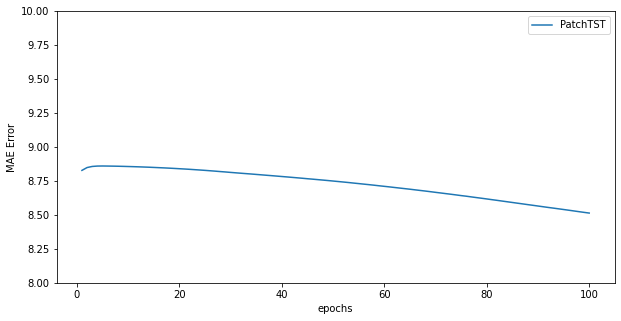

In [244]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, patchtst_learner.epochs+1), patchtst_valid_history, label="PatchTST")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE Error")
ax.set_ylim(8, 10)
ax.legend()
fig.show()

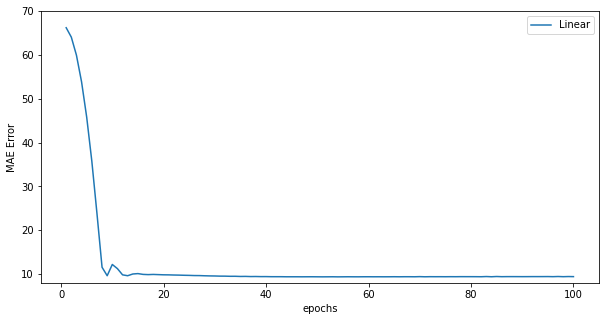

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, Linear_learner.epochs+1), Linear_valid_history, label="Linear")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE Error")
ax.set_ylim(8, 70)
ax.legend()
fig.show()

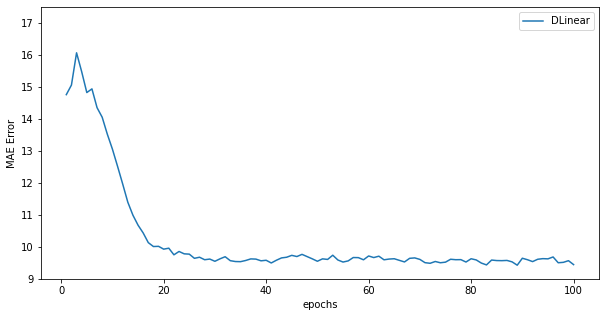

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, DLinear_learner.epochs+1), DLinear_valid_history, label="DLinear")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE Error")
ax.set_ylim(9, 17.5)
ax.legend()
fig.show()

In [265]:
with open('Linear_learner.pkl', 'rb') as file:
    patchtst = pickle.load(file)

In [266]:
x_y = df_ETTh1.iloc[:,:]
a=x_y.shape[0]
print(a*0.8,a*0.9,a)

529274.4 595433.7000000001 661593


In [267]:
X_test = df_ETTh1.iloc[int(a*0.9)//1:int(a//1)-1,0:4]

In [268]:
y_test = df_ETTh1.iloc[int(a*0.9)//1:int(a//1)-1,3]

In [269]:
Xtest = torch.tensor(X_test.values).unsqueeze(0)
Xtest = Xtest.to(torch.float32)
Xtest.shape

torch.Size([1, 66159, 4])

In [270]:
ytest = torch.tensor(y_test.values).unsqueeze(0)
ytest.shape

torch.Size([1, 66159])

torch.Size([50000, 1]) torch.Size([50000, 1])
10.765107154846191
torch.Size([16159, 1]) torch.Size([16159, 1])
10.195148468017578


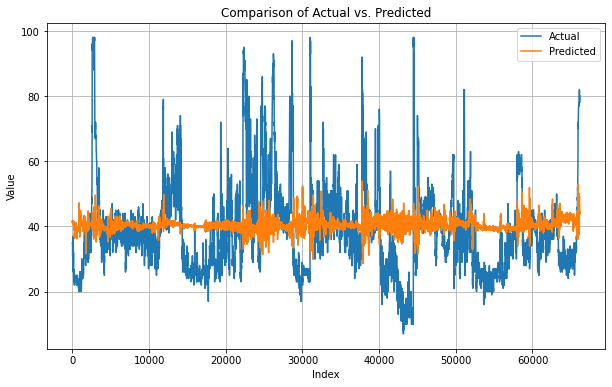

0

In [279]:
def plotter(model):
    total_loss = 0
    iter_count = 0
    y_ = []
    y = []
    for test_x, test_y in model.test_dataloader:
            y.append(test_y)
            test_x = test_x
            test_y = test_y
            pred_y = model.model(test_x)
            y_.append(pred_y)
            loss = model.loss(pred_y, test_y)
            print(pred_y.shape, test_y.shape)
            total_loss += loss.item()
            iter_count += 1
            print(total_loss/iter_count)

    y_pred = torch.cat(y_, dim=0)
    y_test = torch.cat(y, dim=0)


    import matplotlib.pyplot as plt

    # Ensure both arrays have the same length
    assert len(y_pred) == len(y_test), "Length of y_pred and y_test must be the same"

    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.detach().numpy(), label='Actual')
    plt.plot(y_pred.detach().numpy(), label='Predicted')
    plt.title('Comparison of Actual vs. Predicted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    return 0

plotter(Linear_learner)


torch.Size([50000, 1]) torch.Size([50000, 1])
10.672385215759277
torch.Size([16159, 1]) torch.Size([16159, 1])
10.11697244644165


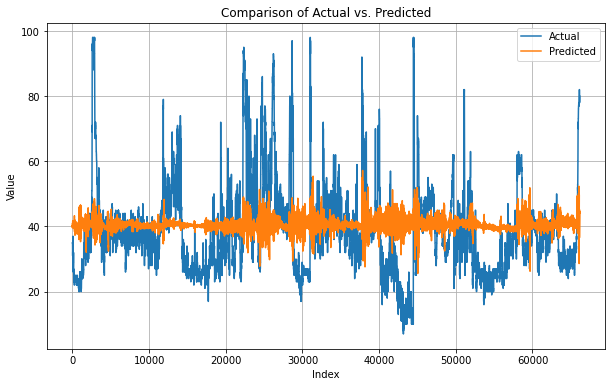

0

In [281]:
plotter(DLinear_learner)

torch.Size([50000, 1]) torch.Size([50000, 1])
11.215527534484863
torch.Size([16159, 1]) torch.Size([16159, 1])
9.18646764755249


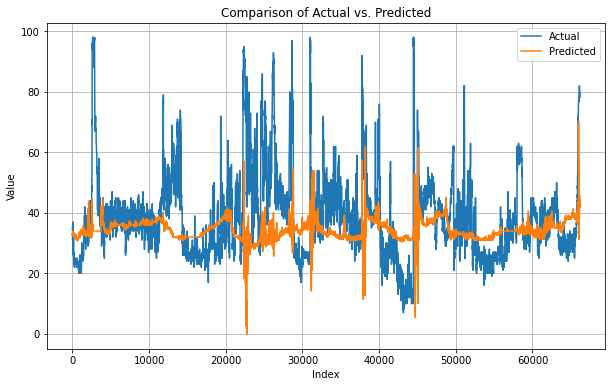

0

In [282]:
plotter(patchtst_learner)